In [ ]:
# Copyright 2024 Gary Ng github.com/gkcng
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# Credits
#
# This code was based on Rohan Jagtap's notebook
# https://github.com/rojagtap/transformer-abstractive-summarization/blob/master/summarizer.ipynb

# Environment

In [1]:
try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd "/content/drive/My Drive/Colab Notebooks/arc_transformer/"

/content/drive/My Drive/Colab Notebooks/arc_transformer


In [3]:
gpu_info = !nvidia-smi 2> /dev/null || echo "failed"
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Mar  4 10:44:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import re
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy.spatial.transform import Rotation

In [5]:
print(tf.__version__)

2.15.0


# Loading Data

In [6]:
!pwd

/content/drive/MyDrive/Colab Notebooks/arc_transformer


In [7]:
# Set some parameters
FG=5 # Feature grid size

im_width  = 5
im_height = 5

# train_dir="tgs-salt-identification-challenge/competition_data/train"
# data_file="data/arc_v6_gsb.npz"
# data_file="data/arc_v7_rotated_gsb.npz"
# data_file="data/arc_v8_rotated_gsb_tasks.npz"
data_file="data/moveapixelxone-5x5_tasks.npz"

In [8]:
data_dict = np.load(data_file, allow_pickle=True)

data   = data_dict["x_train"] # max 32 x 32 grids
labels = data_dict["y_train"] # <task_id>_<dataset>_<example_num>_<inputoutpu> id string
attrs  = data_dict["a_train"] # Metadaa about the task
print(data.shape)

test_data   = data_dict["x_test"] # max 32 x 32 grids
test_labels = data_dict["y_test"] # <task_id>_<dataset>_<example_num>_<inputoutpu> id string
test_attrs  = data_dict["a_test"] # Metadaa about the task
print(test_data.shape)

print("No. of grids = ", len(data))
print("Data shape", data.shape)

(224, 2, 2, 5, 5, 3)
(51, 2, 2, 5, 5, 3)
No. of grids =  224
Data shape (224, 2, 2, 5, 5, 3)


# Data Utiliies

## Padding Utils

In [9]:
# Pad a ARC Task grid for uniformity
def pad_grid(grid, bound_shape=(FG,FG)):
    diff = [ bound_shape[i] - grid.shape[i] for i in range(2) ]
    return np.pad(grid, [(0,diff[0]),(0,diff[1])], mode='constant', constant_values=(10,))

# Removes padding from a ARC Task grid
def trim_grid(padded_grid):
    bounds = padded_grid == 10
    grid = padded_grid[:np.argmax(np.all(bounds, axis=1)), :np.argmax(np.all(bounds, axis=0))]
    # print(grid.shape)
    return grid

## Gyroelongated Square Bipyramid

In [10]:
# Represent the 10 colors with a 3D Gyroelongated Square Bipyramid.
# Coord 0,0,0 is used for padding purposes.
# https://polytope.miraheze.org/wiki/Gyroelongated_square_bipyramid
qurt_8 = np.power(8,1/4)
sqrt_2 = np.power(2,1/2)
# GSB equivalent of the rgbs map
solid  = np.array([
    [0,          0, +(2*sqrt_2 + qurt_8) / 4],
    [0,          0, -(2*sqrt_2 + qurt_8) / 4],
    [+0.5,    +0.5,     qurt_8 / 4],
    [-0.5,    +0.5,     qurt_8 / 4],
    [+0.5,    -0.5,     qurt_8 / 4],
    [-0.5,    -0.5,     qurt_8 / 4],
    [0, +sqrt_2/2, -qurt_8 / 4],
    [0, -sqrt_2/2, -qurt_8 / 4],
    [+sqrt_2/2, 0, -qurt_8 / 4],
    [-sqrt_2/2, 0, -qurt_8 / 4],
    [0,        0,           0]
])
print(solid)

[[ 0.          0.          1.12755499]
 [ 0.          0.         -1.12755499]
 [ 0.5         0.5         0.42044821]
 [-0.5         0.5         0.42044821]
 [ 0.5        -0.5         0.42044821]
 [-0.5        -0.5         0.42044821]
 [ 0.          0.70710678 -0.42044821]
 [ 0.         -0.70710678 -0.42044821]
 [ 0.70710678  0.         -0.42044821]
 [-0.70710678  0.         -0.42044821]
 [ 0.          0.          0.        ]]


In [11]:
# Rotate 45 in all axis to remove any on-axis (zeros) vertices.
r=Rotation.from_euler('xyz',[45,45,45],degrees=True)
solid = r.apply(solid)
print("Rotated GSB Solid")
print(solid)

Rotated GSB Solid
[[ 0.96242838 -0.16512661  0.56377749]
 [-0.96242838  0.16512661 -0.56377749]
 [ 0.53565169  0.61520348  0.10667071]
 [ 0.03565169  0.11520348  0.81377749]
 [ 0.6820983  -0.23834991 -0.39332929]
 [ 0.1820983  -0.73834991  0.31377749]
 [-0.46242838  0.66512661  0.14332929]
 [-0.2553216  -0.54198018 -0.56377749]
 [-0.0053216   0.41512661 -0.7102241 ]
 [-0.71242838 -0.29198018  0.2897759 ]
 [ 0.          0.          0.        ]]


In [12]:
# Retrieve ARC task grid from the GSB representation
gsb_grid_mask = np.tile(solid,(FG,FG,1,1)) # The result shape is (FG, FG, 11, 3)
def gsb_to_grid(gsb_grid):
    g = gsb_grid.copy()
    g = np.expand_dims(g, 2)
    dist = np.linalg.norm(gsb_grid_mask - g, axis=3)
    recovered = np.argmin(dist, axis=2)
    return recovered

def grid_to_gsb(grid):
    new_grid = np.zeros((FG,FG,3))
    for r, row in enumerate(grid):
        for c, cell in enumerate(row):
            new_grid[r][c] = solid[cell]
    return new_grid

# Tests if two GSB grid is the same
def is_same_grid(a, b):
    result = False
    a_grid = gsb_to_grid(a)
    b_grid = gsb_to_grid(b)
    return np.all(a_grid == b_grid)

## RGB Color Utils

In [13]:
# RGB colors of the ARC tasks.
# Added #444444 at index 10 for grid padding
rgbs = ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#444444']
cmap = colors.ListedColormap(rgbs)
norm = colors.Normalize(vmin=0, vmax=10)

# Map #RGB string to 0->1 RGB values
def to_rgb(rgbstr):
    return int(rgbstr[1:3],16) / 255, int(rgbstr[3:5],16) / 255, int(rgbstr[5:7],16) / 255

# Map a ARC task grid to a 3 channels RGB ndarray, usable in imshow.
def grid_to_rgb(color_idx):
    # print(color_idx.shape)
    (h, w) = color_idx.shape
    new_grid = np.zeros((h, w, 3))
    for r, row in enumerate(color_idx):
        for c, cell in enumerate(row):
            R, G, B = to_rgb(rgbs[cell])
            new_grid[r][c][0] = R
            new_grid[r][c][1] = G
            new_grid[r][c][2] = B
    return new_grid

Grid Recovery
Sanity Check:
A rotated gsb should show '[ 0.53565169  0.61520348  0.10667071]'
[0.53565169 0.61520348 0.10667071]


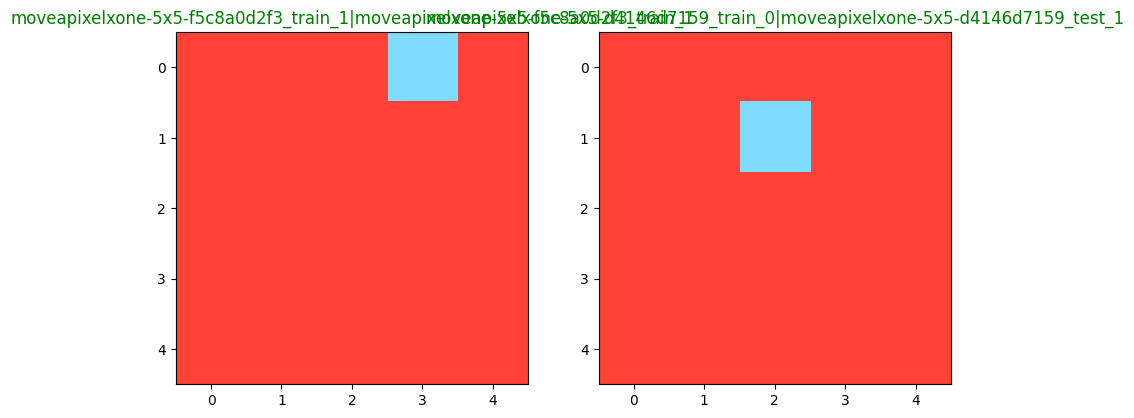

In [14]:
# Visualize any randome image along with the mask
def plot_one(ax, data, label, trim=False):
    grid = gsb_to_grid(data)
    tl_color = 'green' if np.all(grid == grid) else 'red'
    grid = trim_grid(grid) if trim else grid
    xx=grid_to_rgb(grid)
    ax.imshow(xx)
    ax.set_title(label, color=tl_color)

print("Grid Recovery")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 7))
idx = next(i for i, s in enumerate(labels) if s.startswith('moveapixelxone-5x5-f5c8a0d2f3'))
plot_one(ax1, data[idx][0][0], labels[idx])

# print("Sanity Check:\nA rotated gsb should show '[ 0.96242838 -0.16512661  0.56377749]'")
print("Sanity Check:\nA rotated gsb should show '[ 0.53565169  0.61520348  0.10667071]'")
print(data[idx][0][0][0][0]) # idx, encoder. input, top, left.

idx = next(i for i, s in enumerate(test_labels) if s.endswith('d4146d7159_test_1'))
plot_one(ax2, test_data[idx][1][0], test_labels[idx])

## Start and End Tokens

In [15]:
def token_gen(pattern_str):
    ps = pattern_str.split('|')
    print(ps)
    ps_grid = np.array([ list(map(int, list(s))) for s in ps ])
    black = ps_grid == 0
    white = ps_grid == 1
    token_grid = black * 4 + white * 0 # Flip the code to black.
    return pad_grid(token_grid)

['11111', '10001', '10101', '10001', '11111']
['01110', '10101', '11011', '10101', '01110']


Text(0.5, 1.0, 'End')

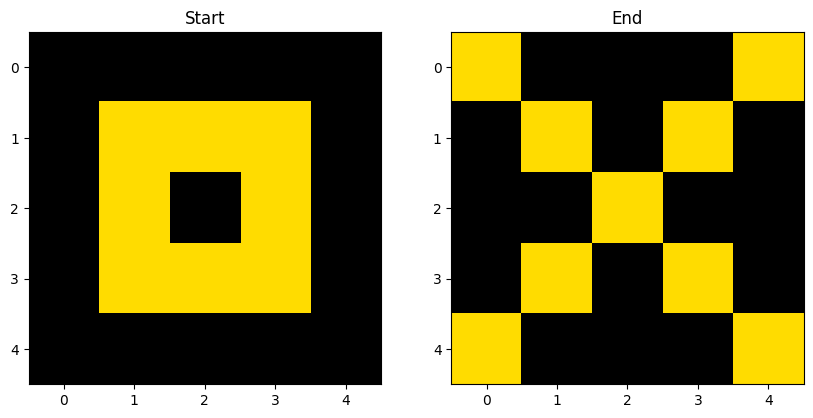

In [16]:
# QR code for "START_TASK" and "END_TASK"
# start_task_grid = token_gen(
# '111111100100001111111|100000100011101000001|101110100010001011101|101110100110001011101|\
# 101110100011101011101|100000101000001000001|111111101010101111111|000000000010000000000|\
# 100101101101110100000|011010011011010100000|111000110111001100101|111100001010101101000|\
# 110000101001011110101|000000001000000011010|111111100001111110110|100000101010000010011|\
# 101110100100111111110|101110101000010000011|101110100101010110001|100000100111100110000|111111101100000110110')
# end_task_grid   = token_gen(
# '111111100110001111111|100000101101001000001|101110100010001011101|101110100011001011101|\
# 101110101111101011101|100000100101001000001|111111101010101111111|000000000010000000000|\
# 101010100010100010010|111010000011011100110|101100101111010110011|011101010001110010000|\
# 011110110001001010111|000000001000001000010|111111100010100110111|100000100010001000010|\
# 101110101000101011100|101110100111010100110|101110101111011111001|100000100101110100010|111111101011011111111')
start_task_grid = token_gen('11111|10001|10101|10001|11111')
end_task_grid   = token_gen('01110|10101|11011|10101|01110')
STOP_TOKEN = grid_to_gsb(end_task_grid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 7))

ax1.imshow(grid_to_rgb(start_task_grid))
ax1.grid(False)
ax1.set_title("Start")

ax2.imshow(grid_to_rgb(end_task_grid))
ax2.grid(False)
ax2.set_title("End")

# Preprocessing

The Data Loaded: (Batch, Encoder/Decoder, Seq, X, Y, Channels)

## Data Parameters

In [17]:
# maxlen - max sequence length
encoder_maxlen = 2
decoder_maxlen = 3
GRID_SHAPE = (FG,FG,3)
zero_grid = np.zeros(GRID_SHAPE)
BUFFER_SIZE = 20000
BATCH_SIZE = 4

## Construct Training and Test Set

In [85]:
class ModelData():
    def __init__(self, data, labels, attrs):
        self.data   = data
        self.labels = labels
        self.attrs  = attrs
        self.enc_inp       = None
        self.enc_inp_model = None
        self.enc_seq_mask  = None
        self.dec_inp       = None
        self.dec_inp_model = None
        self.dec_seq_mask  = None
        self.batches = None
        self._unpack()
        self._repackage()

    def _unpack(self):
        """
        The data's shape is (Batch, Encoder/Decoder, Seq, X, Y, Channels)
        This function split them up and reorganize them into a form more suitable for training and testing.
        . First it separates the Encoder / Decoder Sets as there are different entry points. (Batch, Seq, X, Y, Channels) x 2
        . It adds the STOP token to the decoder sequence.
        """
        print("Unpacking...")
        # np.split separates encoder from decoder => (Batch, 1, Seq, X, Y, Channels), (Batch, 1, Seq, X, Y, Channels)
        # np.squeeze removed the single dim => (Batch, Seq, X, Y, Channels), (Batch, Seq, X, Y, Channels)
        self.enc_inp, self.dec_inp = np.squeeze(np.split(self.data, len(self.data[0]), axis=1))

        ####
        # Encoder - the split output is the result.
        print("Encoder Input Shape: {}".format(self.enc_inp.shape))

        ####
        # Decoder
        # Splits the Sequence into it's constituents (Batch, X, Y, Channels)
        seq = np.squeeze(np.split(self.dec_inp, len(self.dec_inp[0]), axis=1))
        # print([s.shape for s in seq])
        # Attach a STOP_TOKEN to the entire batch (Batch, X, Y, Channels)
        all_stop     = np.repeat([STOP_TOKEN], repeats=self.dec_inp.shape[0], axis=0) # repeat for the entire batch.
        self.dec_inp = np.stack([seq[0], seq[1], all_stop], axis=1)
        # Associate the same labels since it is the same task.
        print("Decoder Input Shape: {}".format(self.dec_inp.shape))

    def _repackage(self):
        print("Repackaging...")
        print("Encoder")
        self.enc_inp_model, self.enc_seq_mask = self._repack(self.enc_inp, encoder_maxlen)
        print("Decoder")
        self.dec_inp_model, self.dec_seq_mask = self._repack(self.dec_inp, decoder_maxlen)
        print(self.enc_inp_model.shape, self.dec_inp_model.shape)

    def _repack(self, data_array, max_seq_length):
        """
        Create structures as required by the model feature length
        Padding/Truncating sequences for identical sequence lengths
        """
        print("Original\t", data_array.shape) # (Batch, Seq, X, Y, Channels)
        # print(data_array[0]) # Entry 0

        ######
        # Create the zero grid padded version (batch, max_len, GRID_SHAPE[0], GRID_SHAPE[1], GRID_SHAPE[2])
        # required as model feature length
        standardized = np.array([ np.concatenate((i, np.tile(zero_grid,(max(max_seq_length-len(i),0),1,1,1))), axis=0) for i in data_array ])
        print("Zero Padded\t", standardized.shape)

        ######
        # Mask: Create the 0 padded (batch, max_len) representaion of the data
        # This is to be used in create_masks.
        # Form [ [ 1's * Seq  ] * Batch ], i.e. for data (10, 2, 5, 5, 3),
        # forms [ [ 1, 1 ] * 10 ] where the inner list is an np.array
        seq_mask = [ np.ones((len(i)), dtype=np.int32) for i in data_array ]
        # Then pad with 0 as a mask to fill the length to max_seq_length,
        # required as model feature length
        seq_mask = tf.keras.preprocessing.sequence.pad_sequences(seq_mask, maxlen=max_seq_length, padding='post', truncating='post')
        print("Sequence Mask\t", seq_mask.shape,seq_mask[0])

        return standardized, seq_mask

    def shuffle_and_batch(self):
        print("Shuffling... use ModelData.batches to retrieve")
        self.batches = tf.data.Dataset.from_tensor_slices(
            (self.enc_inp_model, self.dec_inp_model, self.enc_seq_mask, self.dec_seq_mask)
        ).shuffle(BUFFER_SIZE, seed=0).batch(BATCH_SIZE)

    def plot_task(self, task_id):
        fig, axes = plt.subplots(2, 3, figsize = (15, 15))
        print(labels[task_id])
        plot_one(axes[0,0], self.enc_inp[task_id][0], labels[task_id], trim=False)
        plot_one(axes[0,1], self.enc_inp[task_id][1], labels[task_id], trim=False)
        axes[0,2].axis('off')
        plot_one(axes[1,0], self.dec_inp[task_id][0], labels[task_id], trim=False)
        plot_one(axes[1,1], self.dec_inp[task_id][1], labels[task_id], trim=False)
        plot_one(axes[1,2], self.dec_inp[task_id][2], labels[task_id], trim=False)

In [86]:
training_set = ModelData(data, labels, attrs)
validatn_set = ModelData(test_data, test_labels, test_attrs)

Unpacking...
Encoder Input Shape: (224, 2, 5, 5, 3)
Decoder Input Shape: (224, 3, 5, 5, 3)
Repackaging...
Encoder
Original	 (224, 2, 5, 5, 3)
Zero Padded	 (224, 2, 5, 5, 3)
Sequence Mask	 (224, 2) [1 1]
Decoder
Original	 (224, 3, 5, 5, 3)
Zero Padded	 (224, 3, 5, 5, 3)
Sequence Mask	 (224, 3) [1 1 1]
(224, 2, 5, 5, 3) (224, 3, 5, 5, 3)
Unpacking...
Encoder Input Shape: (51, 2, 5, 5, 3)
Decoder Input Shape: (51, 3, 5, 5, 3)
Repackaging...
Encoder
Original	 (51, 2, 5, 5, 3)
Zero Padded	 (51, 2, 5, 5, 3)
Sequence Mask	 (51, 2) [1 1]
Decoder
Original	 (51, 3, 5, 5, 3)
Zero Padded	 (51, 3, 5, 5, 3)
Sequence Mask	 (51, 3) [1 1 1]
(51, 2, 5, 5, 3) (51, 3, 5, 5, 3)


In [88]:
training_set.shuffle_and_batch()

Shuffling... use ModelData.batches to retrieve


In [90]:
print(training_set.enc_seq_mask.shape)

(224, 2)


moveapixelxone-5x5-7e791d771b_train_1|moveapixelxone-5x5-7e791d771b_train_1


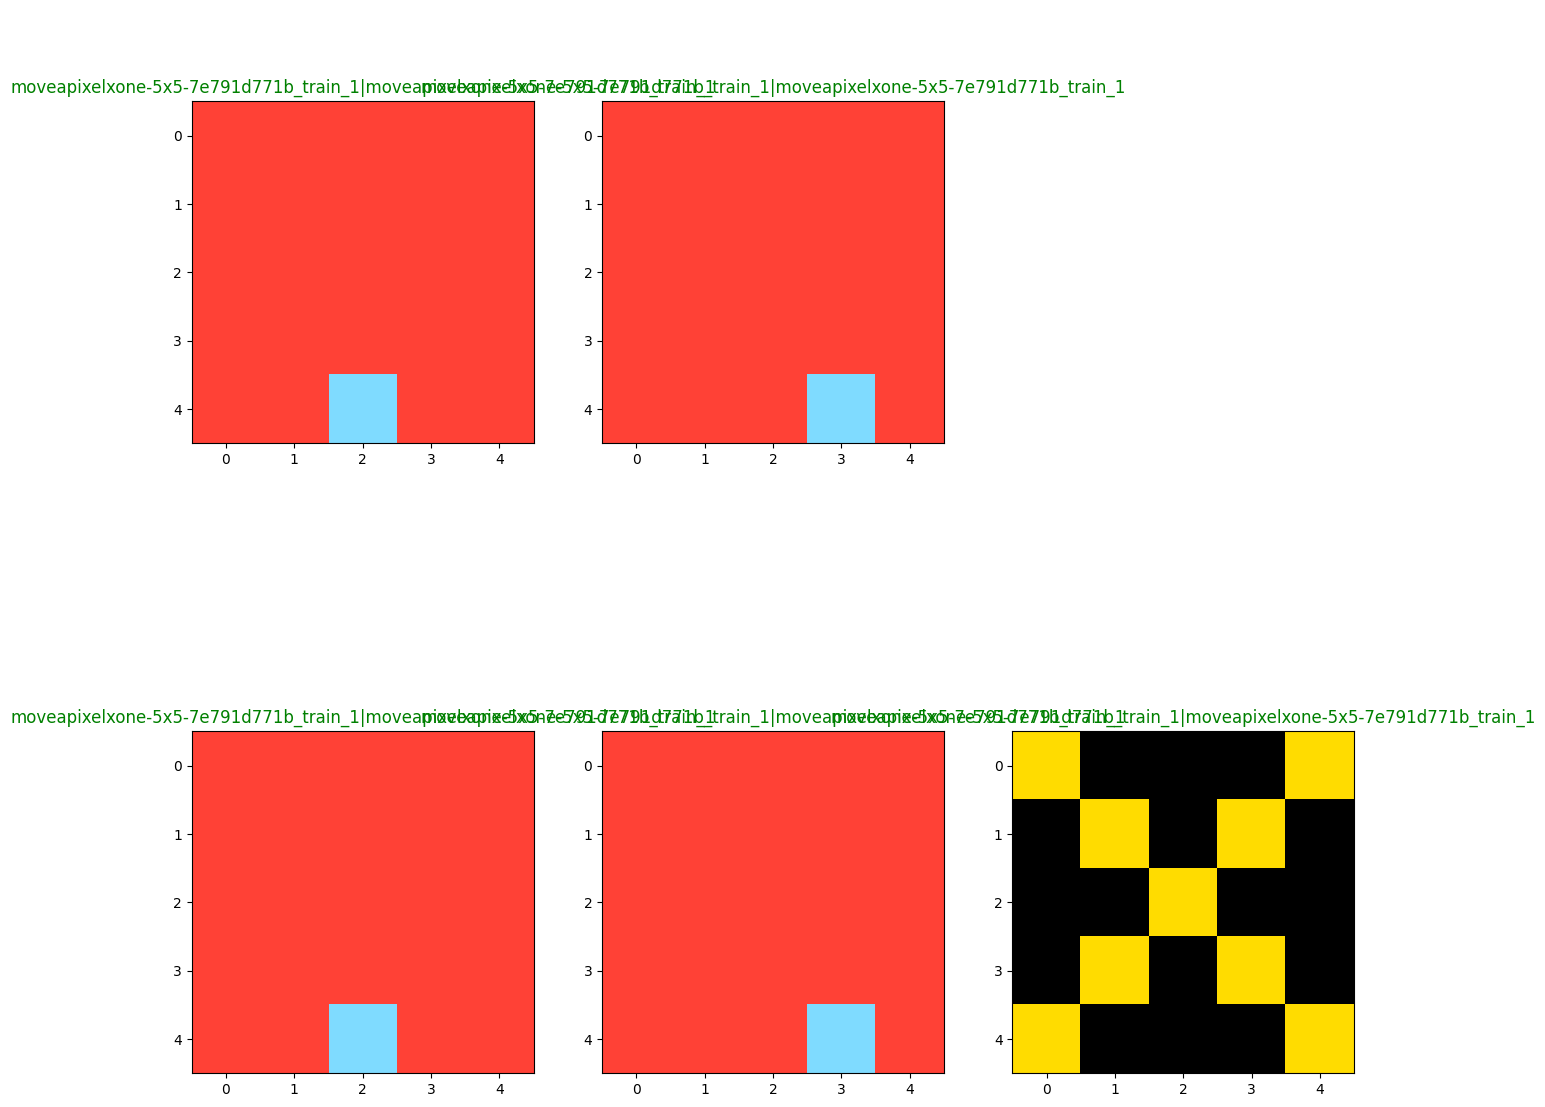

In [91]:
# Take a look at a random task.
task_id = 100
training_set.plot_task(task_id)

# Building the Model

## Positional Encoding

In [22]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

In [23]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


## Masking

- Padding mask for masking "pad" sequences
- Lookahead mask for masking future words from contributing in prediction of current words in self attention
- The mask operation is achieved by adding a large negative number, thus the mask convention 0 for content element, 1 is to be masked.

In [24]:
def create_padding_mask(seq):
    # print("create padding_mask",seq.shape)
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [25]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

## Scaled Dot Product

In [26]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

## Multi-Headed Attention

In [27]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

## Feed Forward Network

In [28]:
def point_wise_feed_forward_network(d_model, dff):
    ffn = tf.keras.Sequential()
    # ffn.add( tf.keras.layers.Dense(dff, activation='relu', kernel_initializer="he_normal") )
    ffn.add( tf.keras.layers.Dense(dff))
    # ffn.add( tf.keras.layers.LeakyReLU())
    ffn.add( tf.keras.layers.PReLU(shared_axes=[1]) )
    ffn.add( tf.keras.layers.Dense(d_model))
    return ffn

## Embedding

In [29]:
class EmbeddingLayer(tf.keras.layers.Layer):
    # say seq_len = 4,
    # Then each should go through the same embedding weights,
    # yield dimention d_model
    #
    # So:
    # Input  (batch_size, seq_len, FG, FG, 3)
    # Output (batch_size, seq_len, d_model)
    #
    def __init__(self, in_shape, d_model):
        super(EmbeddingLayer, self).__init__()

        self.raw = tf.keras.Input(in_shape,name="raw")
        self.flat = tf.keras.layers.Flatten(name="raw_flatten")(self.raw)
        print(self.flat.shape)

        # CNN Layer(s)
        # print(self.raw)
        self.cnn1 = tf.keras.layers.Conv2D(filters=1,kernel_size=(3,3),strides=(1,1),padding="same", name="cnn1")(self.raw) # activation?
        print(self.cnn1.shape)
        self.cnn1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3),strides=(1,1),padding='valid')(self.cnn1)
        print(self.cnn1.shape)
        self.cnn1 = tf.keras.layers.Flatten(name="cnn1_flatten")(self.cnn1)
        print(self.cnn1.shape)

        # Concat
        self.merged = tf.keras.layers.concatenate([self.flat, self.cnn1], axis=-1)
        # self.merged = tf.keras.layers.Dense(d_model, activation='relu', kernel_initializer="he_normal", name="dense")(self.merged)
        print(self.merged.shape)

        self.encoder = tf.keras.Model(inputs=[self.raw],outputs=[self.merged], name = "cnn")

    def call(self, x, training):
        # Apply the same encoder to each element in the sequence
        seq = tf.unstack(x, axis=1)
        emb = [ self.encoder( s ) for s in seq ]
        output = tf.stack(emb, axis=1)

        return output

## Fundamental Unit of Transformer encoder

In [30]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2


## Fundamental Unit of Transformer decoder

In [31]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


## Encoder consisting of multiple EncoderLayer(s)

In [32]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding, embedding_layer, rate):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embedding_layer # tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x


## Decoder consisting of multiple DecoderLayer(s)

In [33]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, maximum_position_encoding, embedding_layer, rate):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embedding_layer # tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights


## Finally, the Transformer

In [114]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, pe_input, pe_target, embedding_layer, rate):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, pe_input, embedding_layer, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, pe_target, embedding_layer, rate)

        self.final_layer = tf.keras.models.Sequential()
        self.final_layer.add( tf.keras.layers.Dense(np.prod(GRID_SHAPE)) )
        self.final_layer.add( tf.keras.layers.Reshape((-1,GRID_SHAPE[0],GRID_SHAPE[1],GRID_SHAPE[2])) ) # <- what's the right param?

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights


# Training Set Up

## Hyperparameters

In [133]:
# hyper-params
num_layers = 1
d_model = 84 # 128
dff = 128
num_heads = 1 # 8
EPOCHS = 130
dropout = 0.1
lr = 1e-03
lr_patience = 8
lr_factor = 0.8

## Custom ReduceLROnPlateau

In [134]:
# Original Callback found in tf.keras.callbacks.Callbac
# Copyright The TensorFlow Authors and Keras Authors.
#
# Modification by Alexander Pelkmann
#   Article: https://medium.com/smart-iot/custom-training-with-custom-callbacks-3bcd117a8f7e
#   Code: https://github.com/Pelk89/TF_Custom_Training_Callbacks
#
class CustomReduceLRoP():

    """Reduce learning rate when a metric has stopped improving.
    Models often benefit from reducing the learning rate by a factor
    of 2-10 once learning stagnates. This callback monitors a
    quantity and if no improvement is seen for a 'patience' number
    of epochs, the learning rate is reduced.

    Arguments:
      monitor: quantity to be monitored.
      factor: factor by which the learning rate will be reduced. new_lr = lr *
        factor
      patience: number of epochs with no improvement after which learning rate
        will be reduced.
      verbose: int. 0: quiet, 1: update messages.
      mode: one of {auto, min, max}. In `min` mode, lr will be reduced when the
        quantity monitored has stopped decreasing; in `max` mode it will be
        reduced when the quantity monitored has stopped increasing; in `auto`
        mode, the direction is automatically inferred from the name of the
        monitored quantity.
      min_delta: threshold for measuring the new optimum, to only focus on
        significant changes.
      cooldown: number of epochs to wait before resuming normal operation after
        lr has been reduced.
      min_lr: lower bound on the learning rate.
    """

    def __init__(self,
                  ## Custom modification:  Deprecated due to focusing on validation loss
                  # monitor='val_loss',
                  factor=0.1,
                  patience=10,
                  verbose=0,
                  mode='auto',
                  min_delta=1e-4,
                  cooldown=0,
                  min_lr=0,
                  sign_number = 4,
                  ## Custom modification: Passing optimizer as arguement
                  optim_lr = None,
                  ## Custom modification:  linearly reduction learning
                  reduce_lin = False,
                  **kwargs):

        ## Custom modification:  Deprecated
        # super(ReduceLROnPlateau, self).__init__()

        ## Custom modification:  Deprecated
        # self.monitor = monitor

        ## Custom modification: Optimizer Error Handling
        if tf.is_tensor(optim_lr) == False:
            raise ValueError('Need optimizer !')
        if factor >= 1.0:
            raise ValueError('ReduceLROnPlateau ' 'does not support a factor >= 1.0.')
        ## Custom modification: Passing optimizer as arguement
        self.optim_lr = optim_lr

        self.factor = factor
        self.min_lr = min_lr
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.cooldown = cooldown
        self.cooldown_counter = 0  # Cooldown counter.
        self.wait = 0
        self.best = 0
        self.mode = mode
        self.monitor_op = None
        self.sign_number = sign_number

        ## Custom modification: linearly reducing learning
        self.reduce_lin = reduce_lin
        self.reduce_lr = True

        self._reset()

    def _reset(self):
        """Resets wait counter and cooldown counter.
        """
        if self.mode not in ['auto', 'min', 'max']:
            print('Learning Rate Plateau Reducing mode %s is unknown, '
                            'fallback to auto mode.', self.mode)
            self.mode = 'auto'
        if (self.mode == 'min' or
                ## Custom modification: Deprecated due to focusing on validation loss
                # (self.mode == 'auto' and 'acc' not in self.monitor)):
                (self.mode == 'auto')):
            self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
            self.best = np.Inf
        else:
            self.monitor_op = lambda a, b: np.greater(a, b + self.min_delta)
            self.best = -np.Inf
        self.cooldown_counter = 0
        self.wait = 0

    def on_train_begin(self, logs=None):
        self._reset()

    def on_epoch_end(self, epoch, loss, logs=None):

        logs = logs or {}
        ## Custom modification: Optimizer
        # logs['lr'] = K.get_value(self.model.optimizer.lr) returns a numpy array
        # and therefore can be modified to
        logs['lr'] = float(self.optim_lr.numpy())

        ## Custom modification: Deprecated due to focusing on validation loss
        # current = logs.get(self.monitor)

        current = float(loss)

        ## Custom modification: Deprecated due to focusing on validation loss
        # if current is None:
        #     print('Reduce LR on plateau conditioned on metric `%s` '
        #                     'which is not available. Available metrics are: %s',
        #                     self.monitor, ','.join(list(logs.keys())))

        # else:

        if self.in_cooldown():
            self.cooldown_counter -= 1
            self.wait = 0

        if self.monitor_op(current, self.best):
            self.best = current
            self.wait = 0
        elif not self.in_cooldown():
            self.wait += 1
            if self.wait >= self.patience:

                ## Custom modification: Optimizer Learning Rate
                # old_lr = float(K.get_value(self.model.optimizer.lr))
                old_lr = float(self.optim_lr.numpy())
                if old_lr > self.min_lr and self.reduce_lr == True:
                    ## Custom modification: Linear learning Rate
                    if self.reduce_lin == True:
                        new_lr = old_lr - self.factor
                        ## Custom modification: Error Handling when learning rate is below zero
                        if new_lr <= 0:
                            print('Learning Rate is below zero: {}, '
                            'fallback to minimal learning rate: {}. '
                            'Stop reducing learning rate during training.'.format(new_lr, self.min_lr))
                            self.reduce_lr = False
                    else:
                        new_lr = old_lr * self.factor

                    new_lr = max(new_lr, self.min_lr)

                    ## Custom modification: Optimizer Learning Rate
                    # K.set_value(self.model.optimizer.lr, new_lr)
                    self.optim_lr.assign(new_lr)

                    if self.verbose > 0:
                        print('\nEpoch %05d: ReduceLROnPlateau reducing learning '
                                'rate to %s.\n' % (epoch + 1, float(new_lr)))
                    self.cooldown_counter = self.cooldown
                    self.wait = 0

    def in_cooldown(self):
        return self.cooldown_counter > 0

## Adam Optimizer

In [135]:
# Defauls, for reference:
#    learning_rate=0.001,
#    beta_1=0.9,
#    beta_2=0.999,
#    epsilon=1e-07,
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9) # tf.keras.optimizers.Adam(learning_rate=lr) #
reduce_rl_plateau = CustomReduceLRoP(patience=lr_patience, factor=lr_factor, verbose=1, optim_lr=optimizer.learning_rate)


## Defining losses and other metrics

In [136]:
loss_object = tf.keras.losses.MeanSquaredError() # tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [137]:
def loss_function(real, pred):
    # mask = tf.math.logical_not(tf.math.equal(real, 0)) # 0->True->False, >0->False->True
    loss_ = loss_object(real, pred)

    # mask = tf.cast(mask, dtype=loss_.dtype) # masked 0, 1 for non-zeros
    # loss_ *= mask # only care about where real was non-zero.

    # return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
    return loss_

In [138]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss   = tf.keras.metrics.Mean(name='val_loss')

## Transformer

In [139]:
transformer = Transformer(
    num_layers,
    d_model,
    num_heads,
    dff,
    encoder_maxlen,
    decoder_maxlen,
    EmbeddingLayer( GRID_SHAPE, d_model),
    dropout
)
# transformer.summary() # This model has not yet been built.

(None, 75)
(None, 5, 5, 1)
(None, 3, 3, 1)
(None, 9)
(None, 84)


## Masks

In [140]:
def create_masks(inp, tar):

    # By the time we got here, inp (encoder input) and tar (decoder input) are already 0 padded.
    # With text inputs, we just need to create the masks from that accordingly.
    # But for this use case, given our inputs are 3D grids, for this function we need
    # a representation of inp (encoder input) and tar (decoder inputs) without the grids.
    # i.e. we need them to be in the form (batch_size, sequence_len)

    # print("create mask",inp.shape, tar.shape)
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask


## Checkpoints

In [141]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer) # tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

## Training steps

In [142]:
for (batch, (inp, tar, inp_pad, tar_pad)) in enumerate(training_set.batches):
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp_pad, tar_pad)
  print(enc_padding_mask.shape, combined_mask.shape, dec_padding_mask.shape)
  print(enc_padding_mask[0])
  print(dec_padding_mask[0])
  print(combined_mask[0])
  break
#
# Illustrating what the training step is doing
#
x = np.array([[1,2,3,4]]*5)
print("Say x is a batch of 10 sequences of 4 elements\n", x)
print("x [:,:-1] is all but last element\n",x[:,:-1])
print("x [:, 1:] is everything but first element\n",x[:, 1:])
print("x [:, 1] is the second element\n",x[:, 1])

(4, 1, 1, 2) (4, 1, 3, 3) (4, 1, 1, 2)
tf.Tensor([[[0. 0.]]], shape=(1, 1, 2), dtype=float32)
tf.Tensor([[[0. 0.]]], shape=(1, 1, 2), dtype=float32)
tf.Tensor(
[[[0. 1. 1.]
  [0. 0. 1.]
  [0. 0. 0.]]], shape=(1, 3, 3), dtype=float32)
Say x is a batch of 10 sequences of 4 elements
 [[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]
x [:,:-1] is all but last element
 [[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]
x [:, 1:] is everything but first element
 [[2 3 4]
 [2 3 4]
 [2 3 4]
 [2 3 4]
 [2 3 4]]
x [:, 1] is the second element
 [2 2 2 2 2]


In [143]:
@tf.function
def train_step(inp, tar, inp_pad, tar_pad):

    tar_inp  = tar[:, :-1] # without stop
    tar_real = tar[:, 1:]  # get the second element
    print("Second element shape", tar_real.shape)

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp_pad, tar_pad[:, :-1])

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp,
            True,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )
        print("Prediction Shape", predictions.shape)
        transformer.summary()
        # predictions, _ = transformer(
        #    inp, tar_inp,
        #    training=True,
        #    enc_padding_mask=enc_padding_mask,
        #    look_ahead_mask=combined_mask,
        #    dec_padding_mask=dec_padding_mask
        # )
        # inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

## Test steps

In [144]:
# Predicting one token at a time at the decoder and appending it to the output;
# then taking the complete sequence as an input to the decoder,
# repeating until maxlen or stop keyword appears
def predict(inp, tar_head, inp_pad, tar_pad):

    encoder_input = inp
    decoder_input = tar_head
    decoder_pad   = tar_pad
    stop_detected = False

    # maxlen = decoder_maxlen # tar_len if tar_len else decoder_maxlen
    for i in range(decoder_maxlen-1):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp_pad, decoder_pad)

        predictions, attention_weights = transformer(
            encoder_input,
            decoder_input,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )
        latest = np.array(predictions[-1,-1])
        if not stop_detected:
            stop_detected = np.all(np.equal(gsb_to_grid(latest), end_task_grid))
        latest_append = np.array(np.expand_dims(latest, axis=(0,1)))
        decoder_input = np.concatenate([decoder_input, latest_append], axis=1)
        decoder_pad   = np.concatenate([decoder_pad, np.ones((1,1))], axis=1)

    return tf.squeeze(decoder_input, axis=0), stop_detected # attention_weights


# Training

In [145]:
history = []
reduce_rl_plateau.on_train_begin()

## Training Loop

In [148]:
for epoch in range(len(history), len(history)+EPOCHS):
    start = time.time()

    train_loss.reset_state()
    val_loss.reset_state()

    for (batch, (inp, tar, inp_pad, tar_pad)) in enumerate(training_set.batches):
        train_step(inp, tar, inp_pad, tar_pad)
        if batch % 20 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))

    # if (epoch + 1) % 20 == 0:
    #    ckpt_save_path = ckpt_manager.save()
    #    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    # Run a validation loop at the end of each epoch.
    # test_step(validatn_set, BATCH_SIZE)
    # print ('Epoch: {} - {:.2f} secs - loss: {:.4f} - val_loss: {:.4f}'.format(epoch + 1, time.time() - start, train_loss.result(), val_loss.result()))
    print ('Epoch: {} - {:.2f} secs - loss: {:.4f}'.format(epoch + 1, time.time() - start, train_loss.result()))

    reduce_rl_plateau.on_epoch_end(epoch, train_loss.result())
    history.append(train_loss.result())


Epoch 131 Batch 0 Loss 0.0018
Epoch 131 Batch 20 Loss 0.0042
Epoch 131 Batch 40 Loss 0.0042
Epoch: 131 - 0.35 secs - loss: 0.0046
Epoch 132 Batch 0 Loss 0.0039
Epoch 132 Batch 20 Loss 0.0049
Epoch 132 Batch 40 Loss 0.0050
Epoch: 132 - 0.40 secs - loss: 0.0049
Epoch 133 Batch 0 Loss 0.0024
Epoch 133 Batch 20 Loss 0.0101
Epoch 133 Batch 40 Loss 0.0072
Epoch: 133 - 0.34 secs - loss: 0.0095
Epoch 134 Batch 0 Loss 0.0071
Epoch 134 Batch 20 Loss 0.0112
Epoch 134 Batch 40 Loss 0.0080
Epoch: 134 - 0.36 secs - loss: 0.0076
Epoch 135 Batch 0 Loss 0.0376
Epoch 135 Batch 20 Loss 0.0079
Epoch 135 Batch 40 Loss 0.0068
Epoch: 135 - 0.34 secs - loss: 0.0081
Epoch 136 Batch 0 Loss 0.0023
Epoch 136 Batch 20 Loss 0.0054
Epoch 136 Batch 40 Loss 0.0087
Epoch: 136 - 0.34 secs - loss: 0.0075
Epoch 137 Batch 0 Loss 0.0012
Epoch 137 Batch 20 Loss 0.0054
Epoch 137 Batch 40 Loss 0.0077
Epoch: 137 - 0.35 secs - loss: 0.0068
Epoch 138 Batch 0 Loss 0.0015
Epoch 138 Batch 20 Loss 0.0079
Epoch 138 Batch 40 Loss 0.006

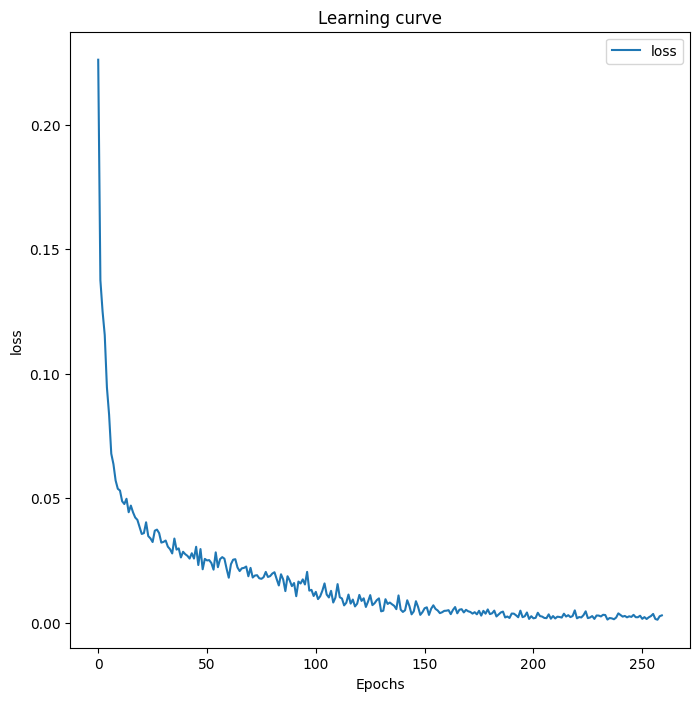

In [149]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history, label="loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();
# transformer.summary()

## Survey Model Weights

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  50768     
                                                                 
 decoder_1 (Decoder)         multiple                  79496     
                                                                 
 sequential_5 (Sequential)   (4, 2, 5, 5, 3)           6375      
                                                                 
Total params: 136611 (533.64 KB)
Trainable params: 136611 (533.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


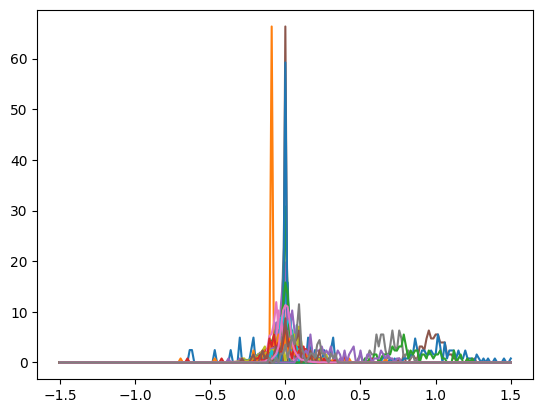

In [150]:
transformer.summary()
# weights = transformer.get_weights()
for w in transformer.trainable_weights:
    # print(np.sum(np.isnan(w)))
    pr, _ = np.histogram(w, bins=np.linspace(-1.5, 1.5, 200), density=True)
    plt.plot(np.linspace(-1.5, 1.5, len(pr)), pr) # , label='real', color='g', linewidth=2)

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


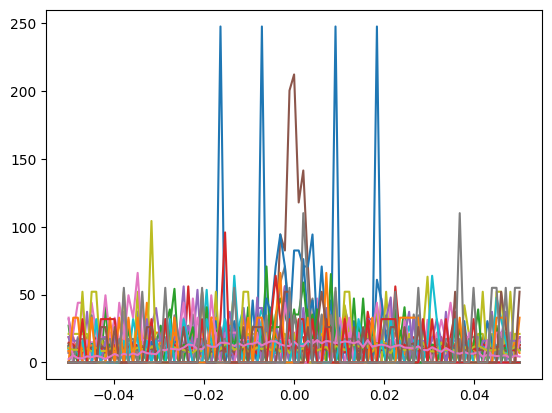

In [151]:
for w in transformer.trainable_weights:
    # print(np.sum(np.isnan(w)))
    pr, _ = np.histogram(w, bins=np.linspace(-0.05, 0.05, 100), density=True)
    plt.plot(np.linspace(-0.05, 0.05, len(pr)), pr) # , label='real', color='g', linewidth=2)
# plt.clf()

# Inference

In [152]:
def solve_one(inp, tar, inp_pad, tar_pad):
    inp_ = np.expand_dims(inp, axis=0)
    tar_ = np.expand_dims(tar[0], axis=(0,1))
    inp_pad_ = np.expand_dims(inp_pad, axis=0)
    tar_pad_ = np.expand_dims(tar_pad[0], axis=(0,1))
    pred, stop_detected = predict( inp_, tar_, inp_pad_, tar_pad_)
    loss = loss_function(tar, pred)
    return pred, loss, stop_detected

In [153]:
def test_step(validatn_set, batch_size):
    (inp, tar, inp_pad, tar_pad) = validatn_set
    for idx in range(batch_size):
        _, loss, _ = solve_one(inp[idx], tar[idx], inp_pad[idx], tar_pad[idx])
        val_loss(loss)

In [154]:
def is_exact_match(target, prediction):
    tar_grid = np.array(list(map(gsb_to_grid, target)))
    pred_grid= np.array(list(map(gsb_to_grid, prediction.numpy())))
    return np.all(np.equal(tar_grid,pred_grid))

## Solving and Plotting Utilities

In [155]:
# Plot task grids
def plot_task( inp, tar, pred, idx ):
    fig, axes = plt.subplots(1, len(inp[idx]), figsize = (7, 20))
    for i in range(len(inp[idx])):
        plot_one(axes[i], np.array(inp[idx][i]), "", trim=False)
    fig, axes = plt.subplots(1, len(tar[idx]), figsize = (15, 20))
    for i in range(len(tar[idx])):
        plot_one(axes[i], np.array(tar[idx][i]), "", trim=False)
    fig, axes = plt.subplots(1, len(pred), figsize = (15, 20))
    for i in range(len(pred)):
        plot_one(axes[i], np.array(pred[i]), "", trim=False)

In [156]:
def solve_and_plot(from_dataset, idxs=None):

    inp_labels    = from_dataset.labels
    target_labels = from_dataset.labels
    inp           = from_dataset.enc_inp_model
    inp_pad       = from_dataset.enc_seq_mask
    tar           = from_dataset.dec_inp_model
    tar_pad       = from_dataset.dec_seq_mask

    if not idxs:
        # Pick a random one
        idxs = [np.random.randint(0, len(inp))]

    for idx in idxs:
        print("Task index: {}, Input: {}, Target: {}".format(idx, inp_labels[idx], target_labels[idx]))
        # Run prediction
        pred, loss, stop_detected = solve_one(inp[idx], tar[idx], inp_pad[idx], tar_pad[idx])
        accurate = is_exact_match(tar[idx], pred)
        print("Result Elements: {}, Accurate: {}, Shape: {}, Stopped: {}".format(len(pred), accurate, pred.shape, stop_detected))
        print("Loss", loss)
        plot_task( inp, tar, pred, idx )

## Random Pick from Training Set

Task index: 181, Input: moveapixelxone-5x5-dd61478799_train_2|moveapixelxone-5x5-dd61478799_train_3, Target: moveapixelxone-5x5-dd61478799_train_2|moveapixelxone-5x5-dd61478799_train_3
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0002372339596114193, shape=(), dtype=float64)


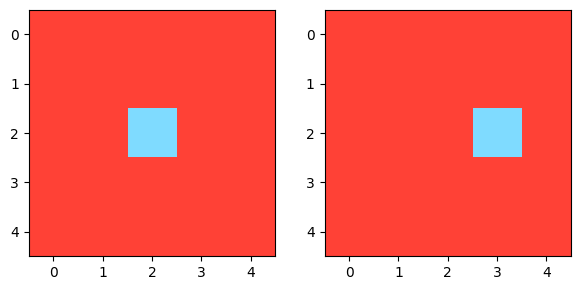

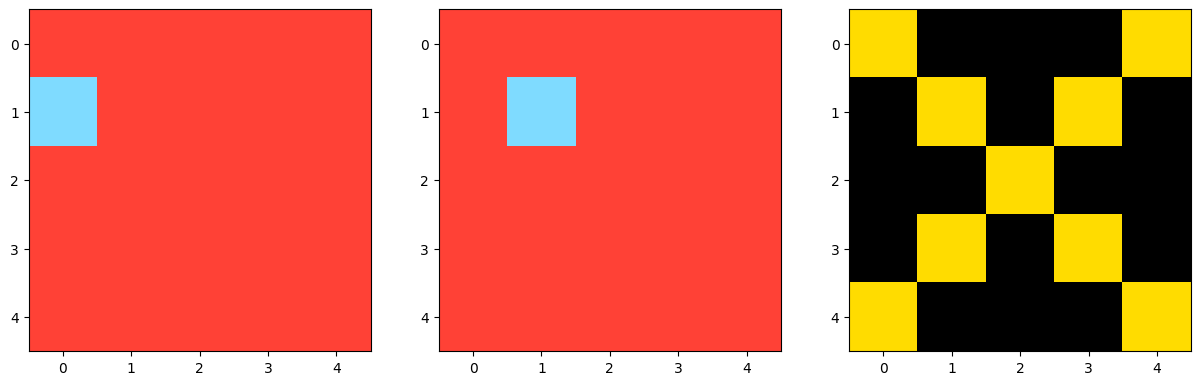

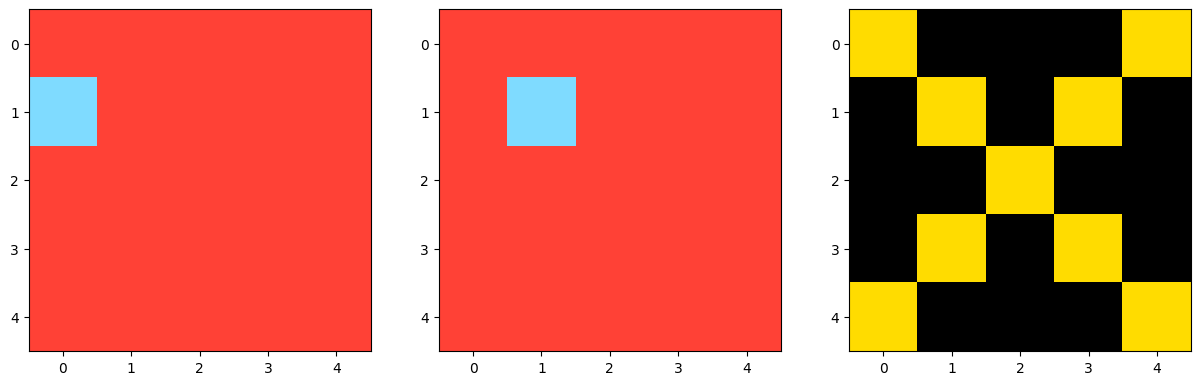

In [157]:
solve_and_plot(training_set)

## Random Pick from Test Set

Task index: 44, Input: moveapixelxone-5x5-ed3c40cfc9_train_0|moveapixelxone-5x5-ed3c40cfc9_test_0, Target: moveapixelxone-5x5-ed3c40cfc9_train_0|moveapixelxone-5x5-ed3c40cfc9_test_0
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: False
Loss tf.Tensor(0.10220514471811906, shape=(), dtype=float64)


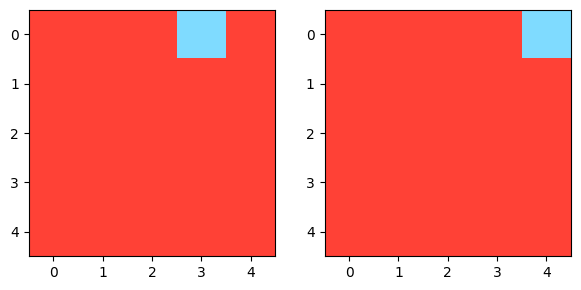

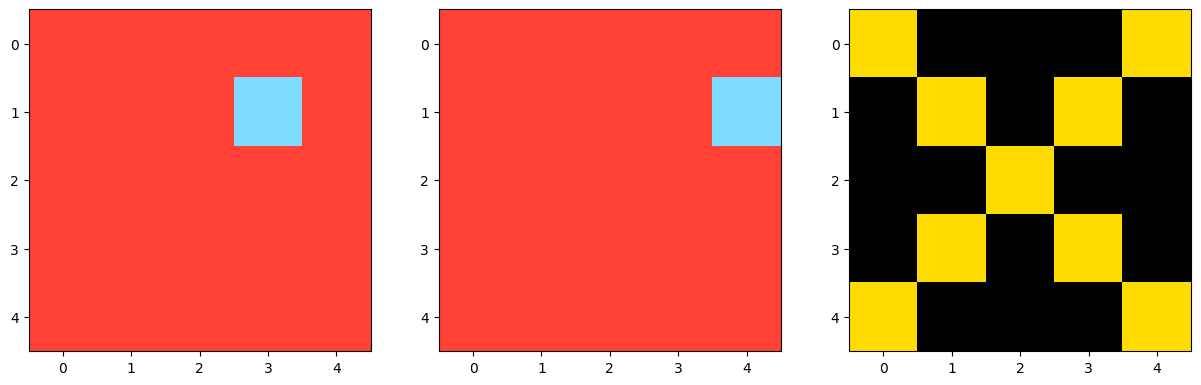

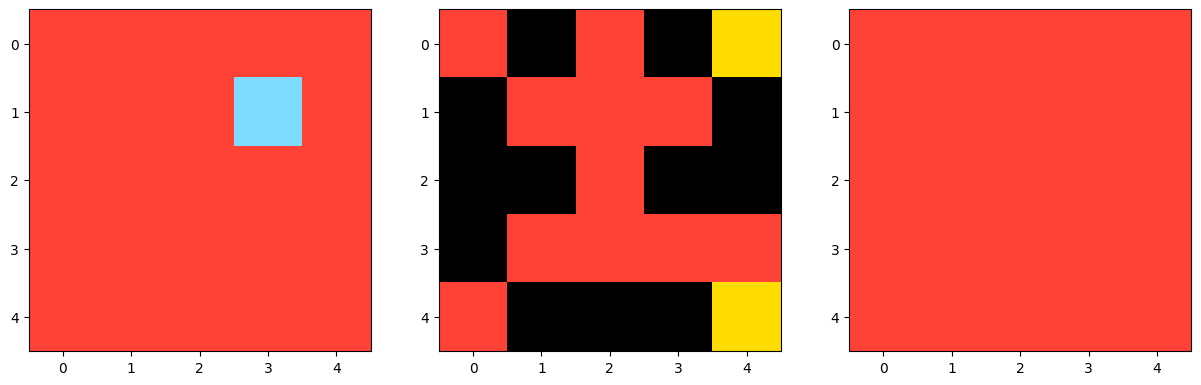

In [158]:
solve_and_plot(validatn_set)

## Try some known test cases

moveapixelxone-5x5-f5c8a0d2f3_train_2|moveapixelxone-5x5-f5c8a0d2f3_train_1
moveapixelxone-5x5-ed3c40cfc9_train_1|moveapixelxone-5x5-ed3c40cfc9_train_2
moveapixelxone-5x5-dd6fc0acab_train_2|moveapixelxone-5x5-dd6fc0acab_train_2
Task index: 217, Input: moveapixelxone-5x5-f5c8a0d2f3_train_2|moveapixelxone-5x5-f5c8a0d2f3_train_1, Target: moveapixelxone-5x5-f5c8a0d2f3_train_2|moveapixelxone-5x5-f5c8a0d2f3_train_1
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.00013145735310499167, shape=(), dtype=float64)
Task index: 198, Input: moveapixelxone-5x5-ed3c40cfc9_train_1|moveapixelxone-5x5-ed3c40cfc9_train_2, Target: moveapixelxone-5x5-ed3c40cfc9_train_1|moveapixelxone-5x5-ed3c40cfc9_train_2
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.00032460162991784173, shape=(), dtype=float64)
Task index: 191, Input: moveapixelxone-5x5-dd6fc0acab_train_2|moveapixelxone-5x5-dd6fc0acab_train_2, Target: moveapixelxone-5x5-dd6f

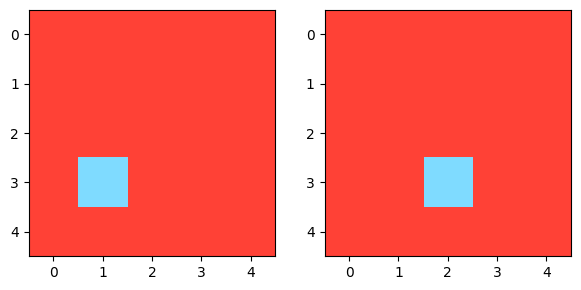

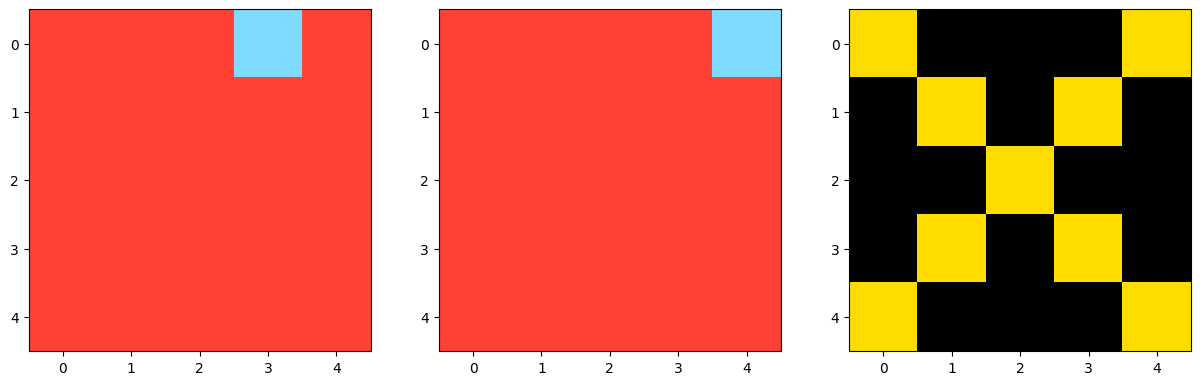

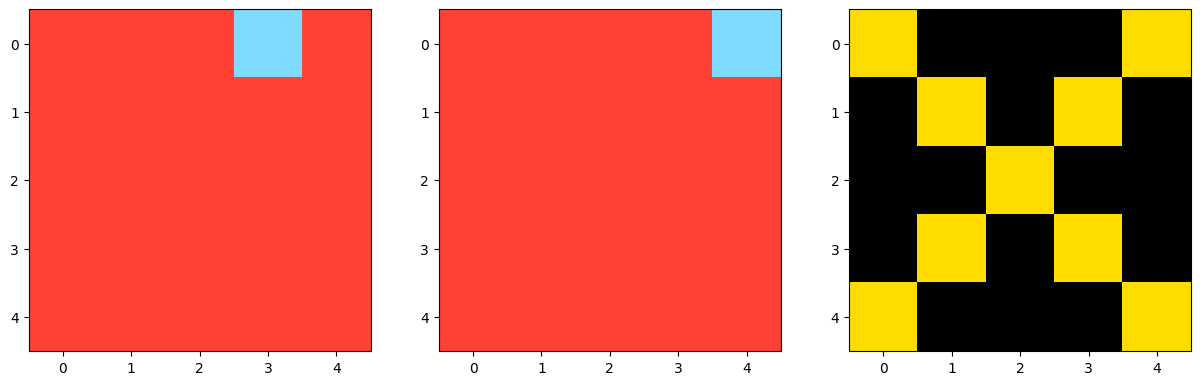

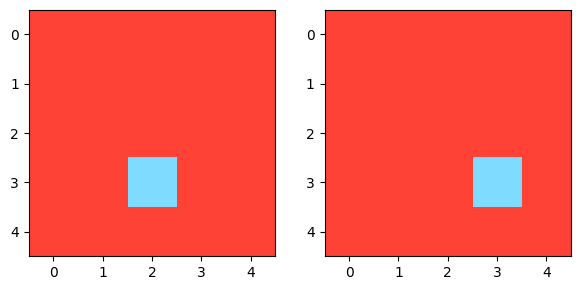

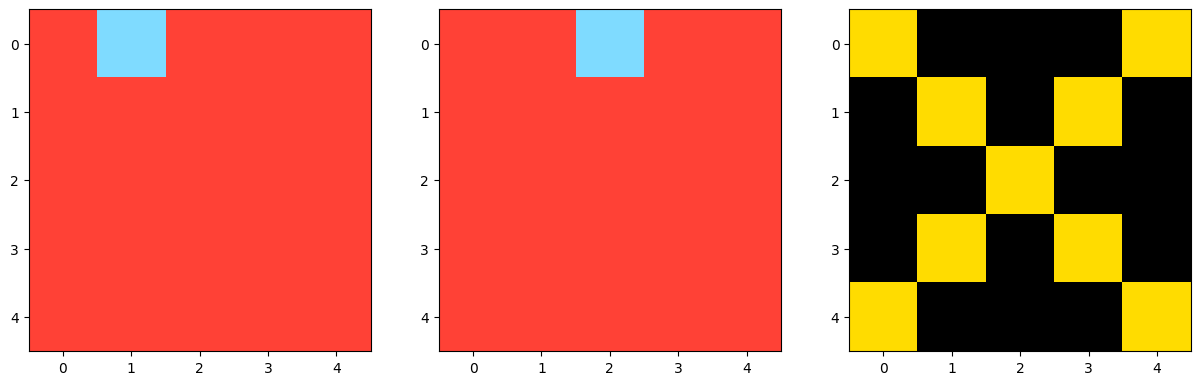

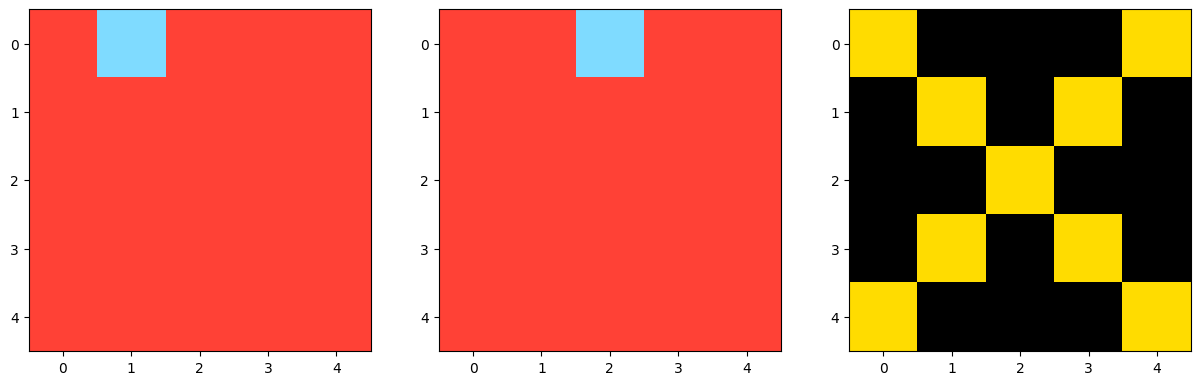

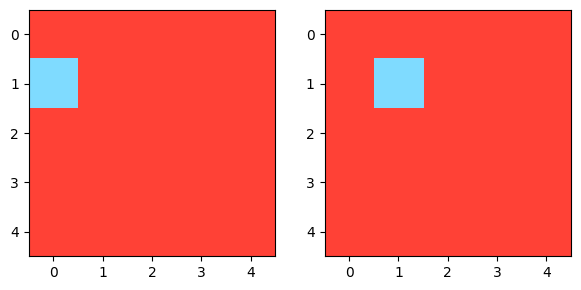

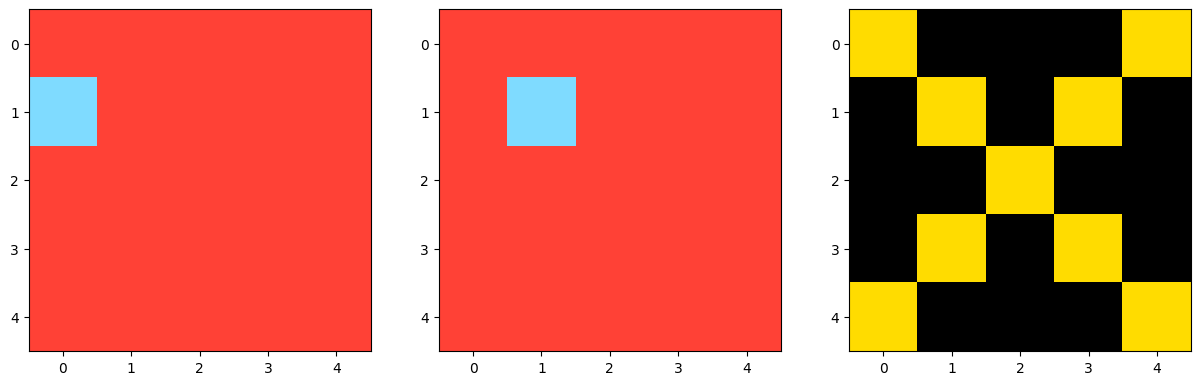

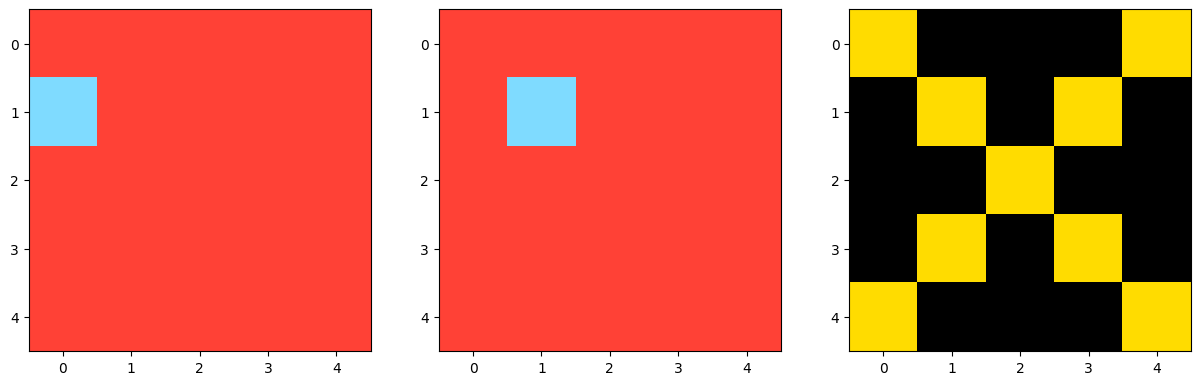

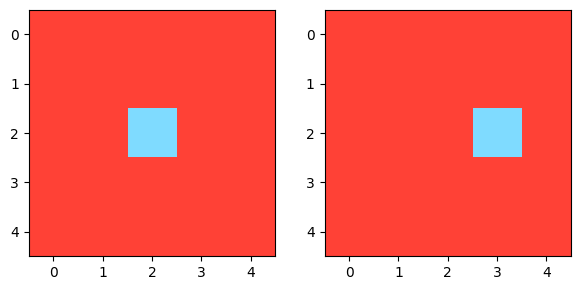

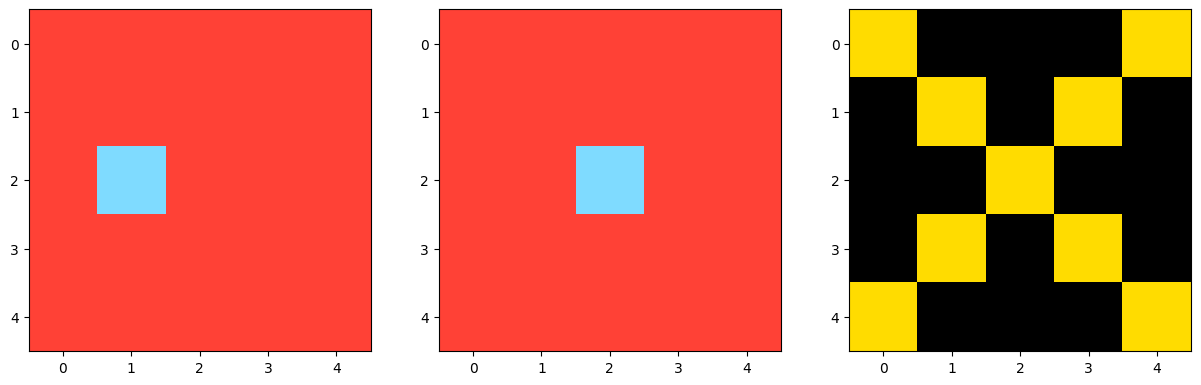

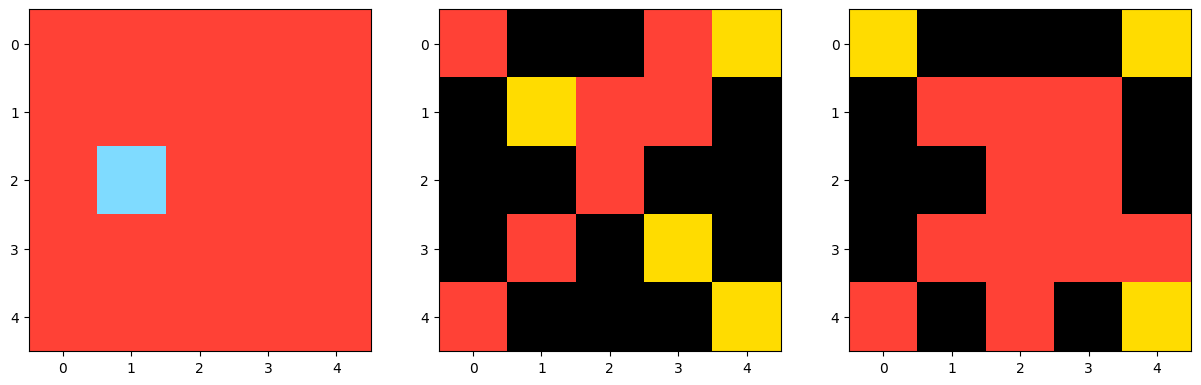

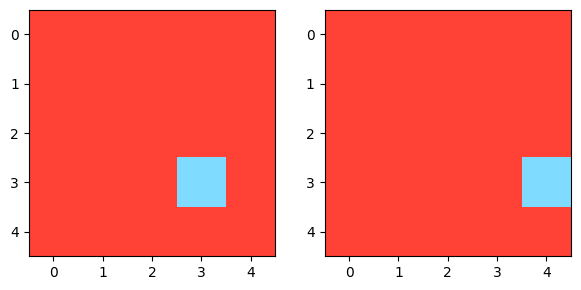

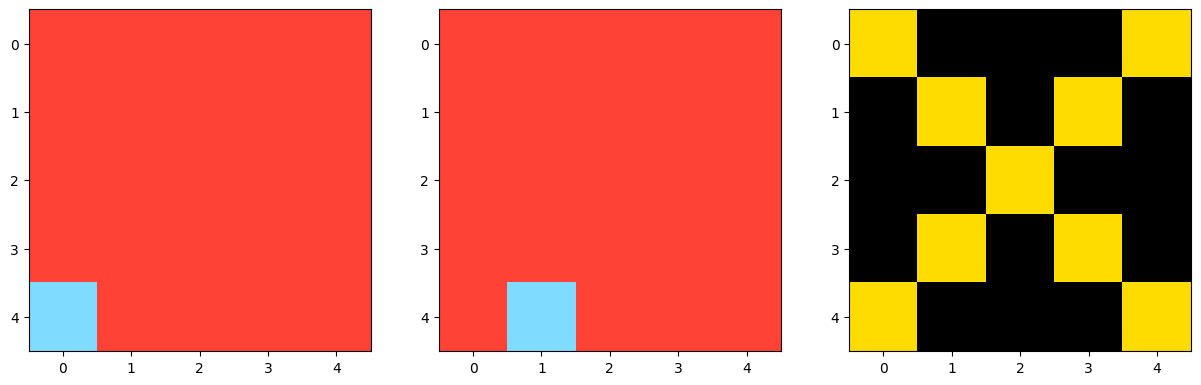

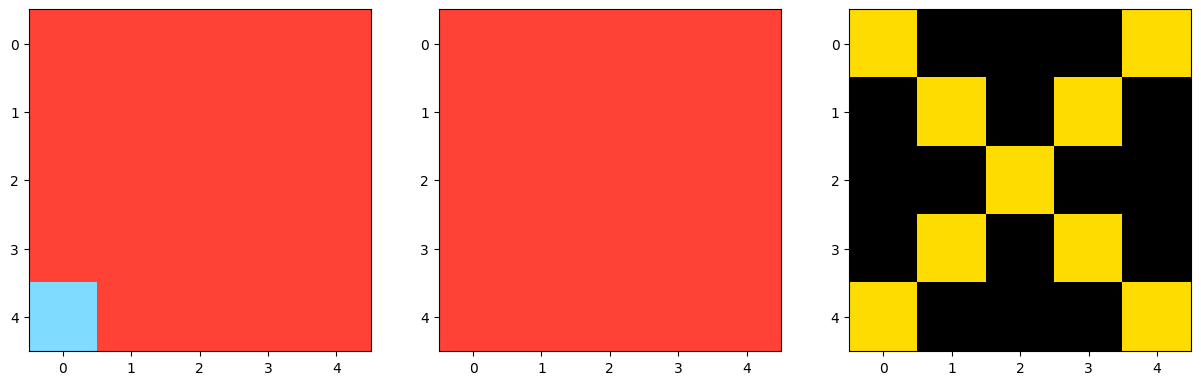

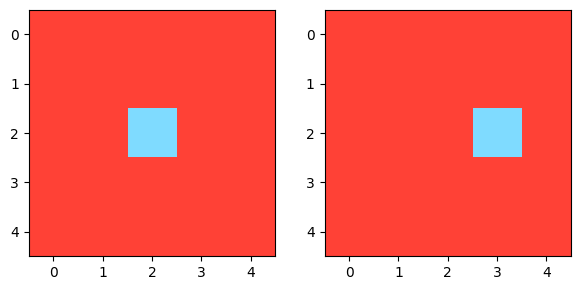

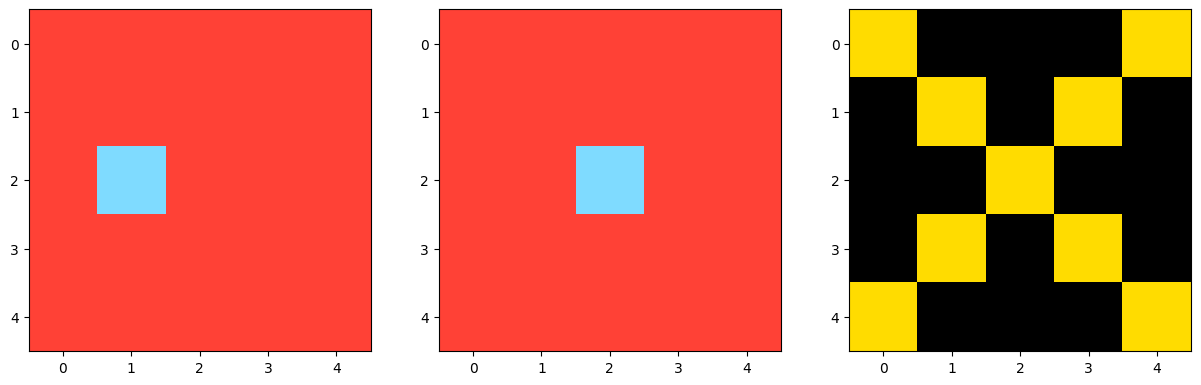

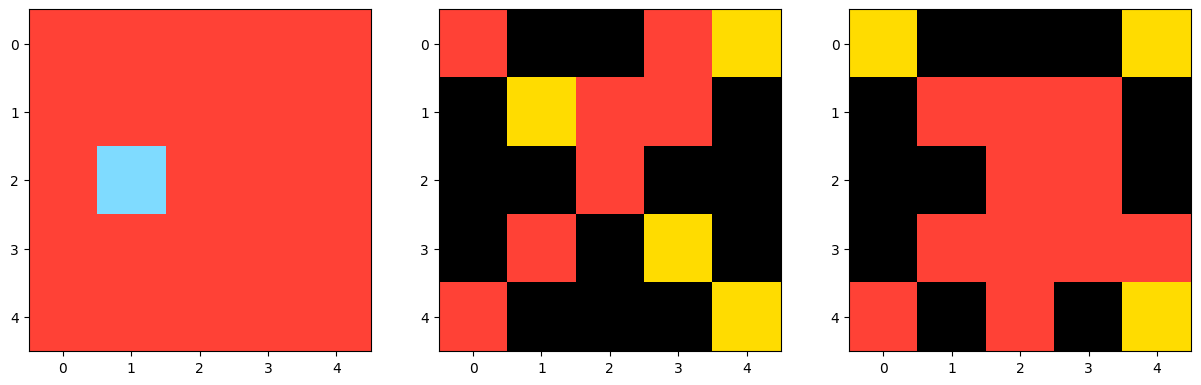

In [159]:
cases = ['moveapixelxone-5x5-f5c8a0d2f3_train_2|moveapixelxone-5x5-f5c8a0d2f3_train_1',
         'moveapixelxone-5x5-ed3c40cfc9_train_1|moveapixelxone-5x5-ed3c40cfc9_train_2',
         'moveapixelxone-5x5-dd6fc0acab_train_2|moveapixelxone-5x5-dd6fc0acab_train_2']
inds = []
for c in cases:
    print(c)
    inds.append(next(i for i, s in enumerate(training_set.labels) if s.startswith(c)))
solve_and_plot(training_set, inds)

cases = ['moveapixelxone-5x5-dd61478799_train_0|moveapixelxone-5x5-dd61478799_test_0',
         'moveapixelxone-5x5-a1b7d98a6b_train_0|moveapixelxone-5x5-a1b7d98a6b_test_0',
         'moveapixelxone-5x5-dd61478799_train_0|moveapixelxone-5x5-dd61478799_test_0']
inds = []
for c in cases:
    inds.append(next(i for i, s in enumerate(validatn_set.labels) if s.endswith(c)))
solve_and_plot(validatn_set, inds)


# Score Test Set

In [160]:
def score(data_set):

  val_loss.reset_states()
  stops_found=0
  accurate=[]

  inp           = data_set.enc_inp_model
  inp_pad       = data_set.enc_seq_mask
  tar           = data_set.dec_inp_model
  tar_pad       = data_set.dec_seq_mask
  for idx in range(len(inp)):
      pred, loss, stop_detected = solve_one(inp[idx], tar[idx], inp_pad[idx], tar_pad[idx])
      if is_exact_match(tar[idx], pred):
          accurate.append(idx)
      val_loss(loss)
      stops_found+= stop_detected
      if idx % np.around(len(inp) / 10) == 0:
          print("processed", idx)

  print("Count: {}, Avg loss: {:.4f}, Accuracy: {} ({:.4f}), Stops found: {}".format(len(inp), val_loss.result(), len(accurate), len(accurate)/len(inp), stops_found))
  return accurate

In [161]:
correct_idxs = score(validatn_set)
print(correct_idxs)

processed 0
processed 5
processed 10
processed 15
processed 20
processed 25
processed 30
processed 35
processed 40
processed 45
processed 50
Count: 51, Avg loss: 0.0693, Accuracy: 0 (0.0000), Stops found: 43
[]


Task index: 20, Input: moveapixelxone-5x5-64378d811f_train_0|moveapixelxone-5x5-64378d811f_test_0, Target: moveapixelxone-5x5-64378d811f_train_0|moveapixelxone-5x5-64378d811f_test_0
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.14014471234109313, shape=(), dtype=float64)


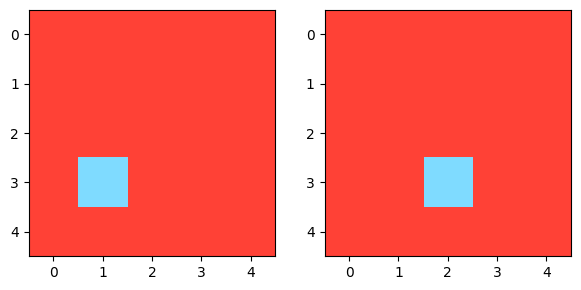

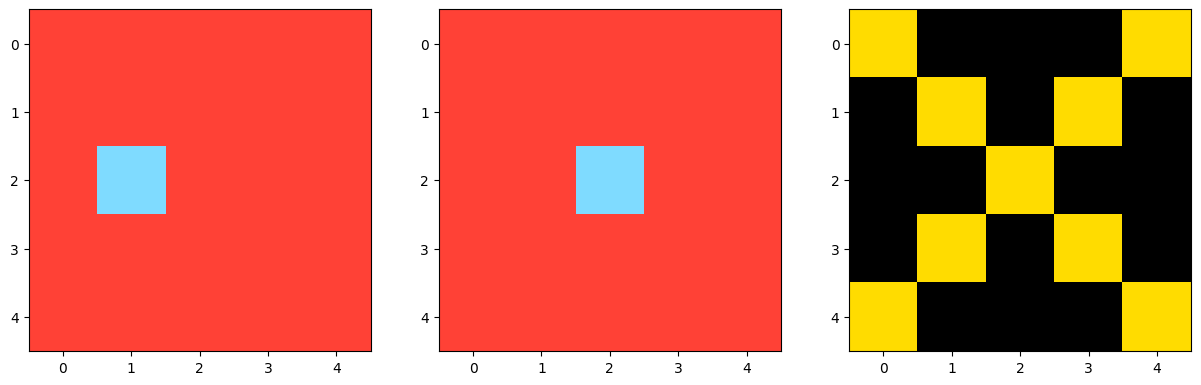

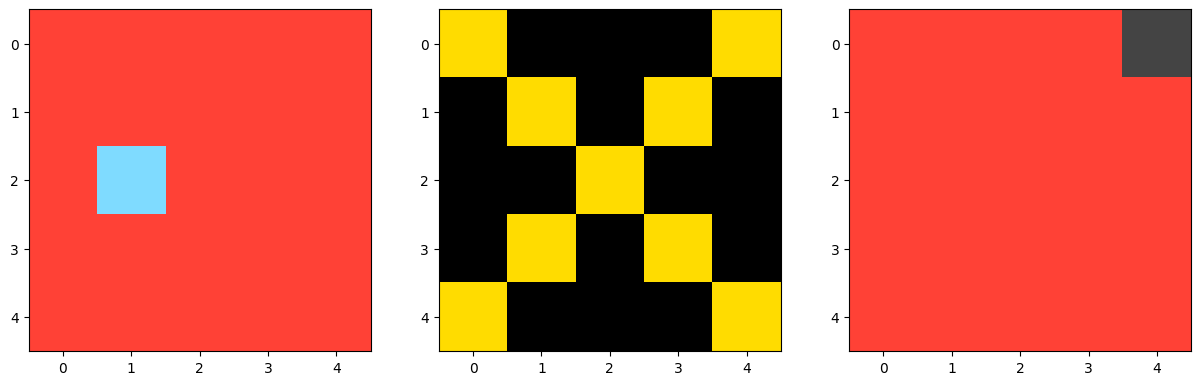

In [162]:
solve_and_plot(validatn_set, correct_idxs)

# Score Train Set

In [163]:
correct_idxs = score(training_set)
print(correct_idxs)

processed 0
processed 22
processed 44
processed 66
processed 88
processed 110
processed 132
processed 154
processed 176
processed 198
processed 220
Count: 224, Avg loss: 0.0002, Accuracy: 224 (1.0000), Stops found: 224
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 

## Plot Correct Train Tasks

224
[75, 182, 56, 200, 66, 39, 13, 190, 65, 19]
Task index: 75, Input: moveapixelxone-5x5-4842b6aaf6_train_2|moveapixelxone-5x5-4842b6aaf6_train_2, Target: moveapixelxone-5x5-4842b6aaf6_train_2|moveapixelxone-5x5-4842b6aaf6_train_2
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.00019616881175691986, shape=(), dtype=float64)
Task index: 182, Input: moveapixelxone-5x5-dd61478799_train_3|moveapixelxone-5x5-dd61478799_train_3, Target: moveapixelxone-5x5-dd61478799_train_3|moveapixelxone-5x5-dd61478799_train_3
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.00017914328488530007, shape=(), dtype=float64)
Task index: 56, Input: moveapixelxone-5x5-3b6ec14321_train_1|moveapixelxone-5x5-3b6ec14321_train_2, Target: moveapixelxone-5x5-3b6ec14321_train_1|moveapixelxone-5x5-3b6ec14321_train_2
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.00014665314472736283, shape=(), dtype=flo

<ipython-input-155-4dd048e1be48>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(pred), figsize = (15, 20))


Task index: 190, Input: moveapixelxone-5x5-dd6fc0acab_train_1|moveapixelxone-5x5-dd6fc0acab_train_2, Target: moveapixelxone-5x5-dd6fc0acab_train_1|moveapixelxone-5x5-dd6fc0acab_train_2
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.00017914328488530007, shape=(), dtype=float64)
Task index: 65, Input: moveapixelxone-5x5-3b6ec14321_train_2|moveapixelxone-5x5-3b6ec14321_train_4, Target: moveapixelxone-5x5-3b6ec14321_train_2|moveapixelxone-5x5-3b6ec14321_train_4
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(8.759175015065438e-05, shape=(), dtype=float64)
Task index: 19, Input: moveapixelxone-5x5-10c47e4c10_train_2|moveapixelxone-5x5-10c47e4c10_train_2, Target: moveapixelxone-5x5-10c47e4c10_train_2|moveapixelxone-5x5-10c47e4c10_train_2
Result Elements: 3, Accurate: True, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.0005051230558039782, shape=(), dtype=float64)


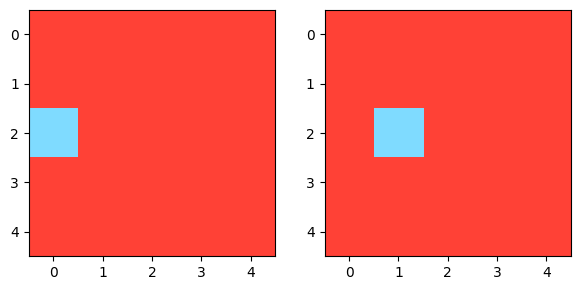

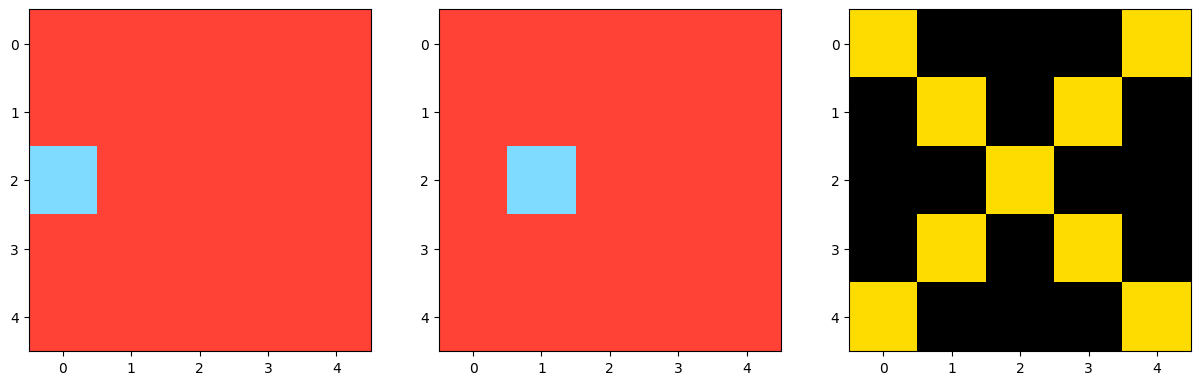

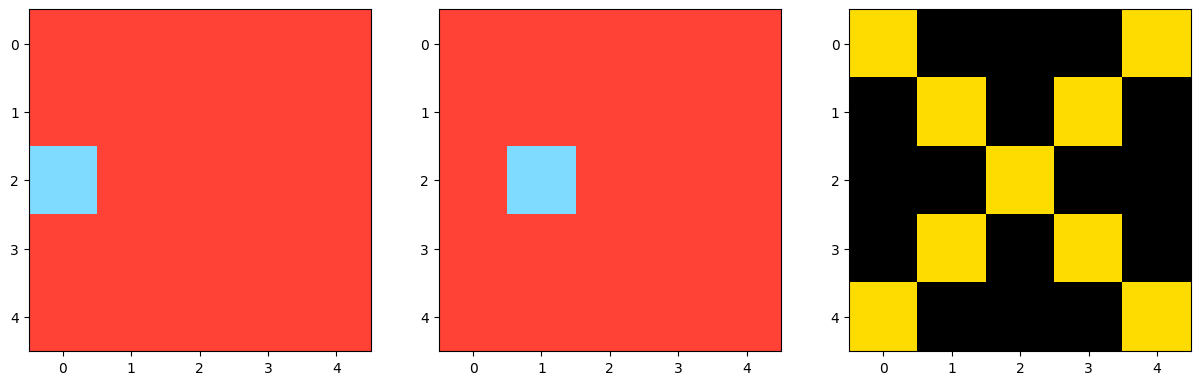

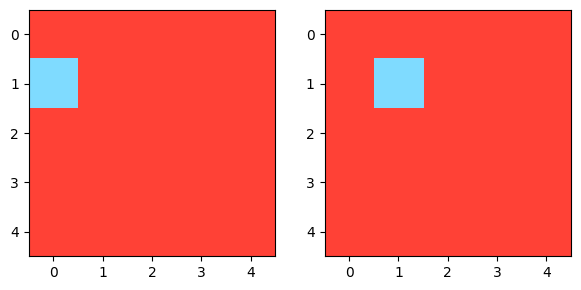

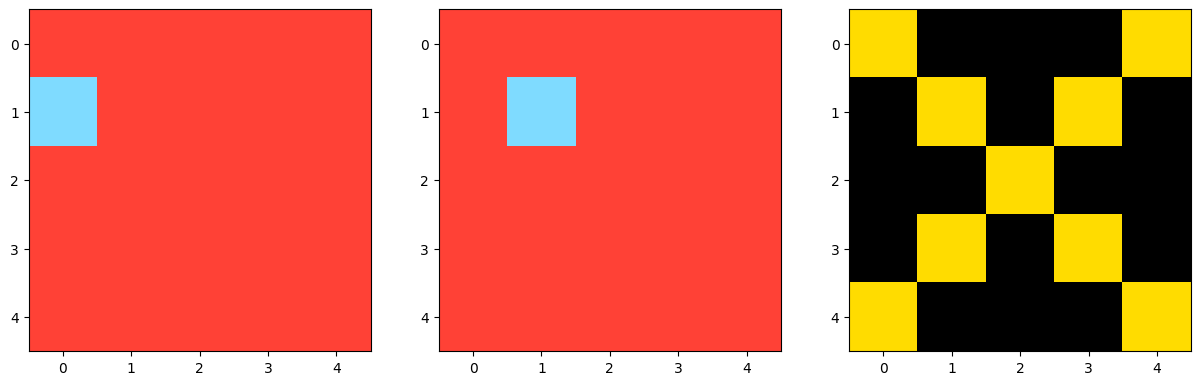

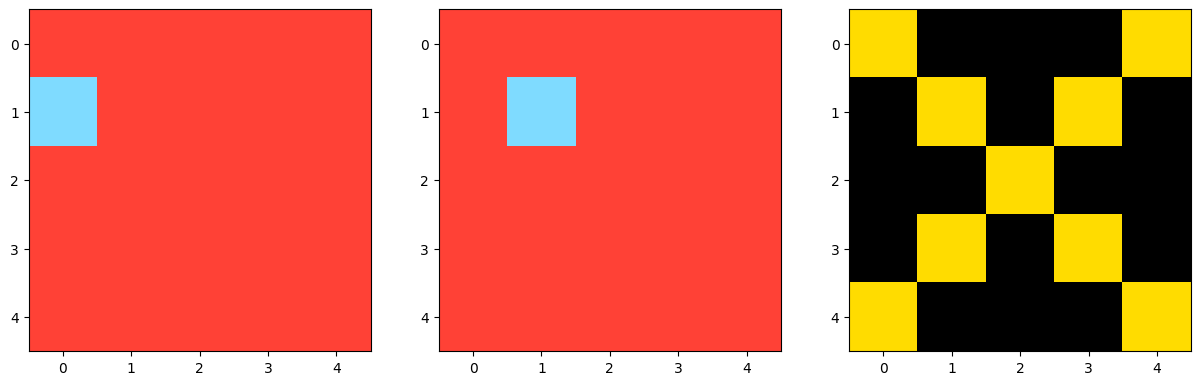

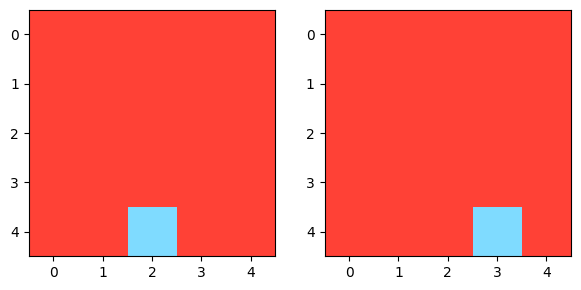

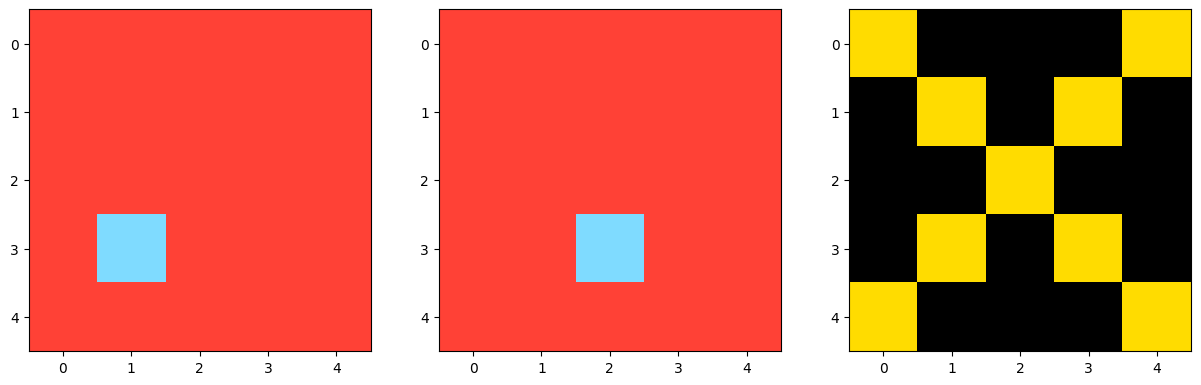

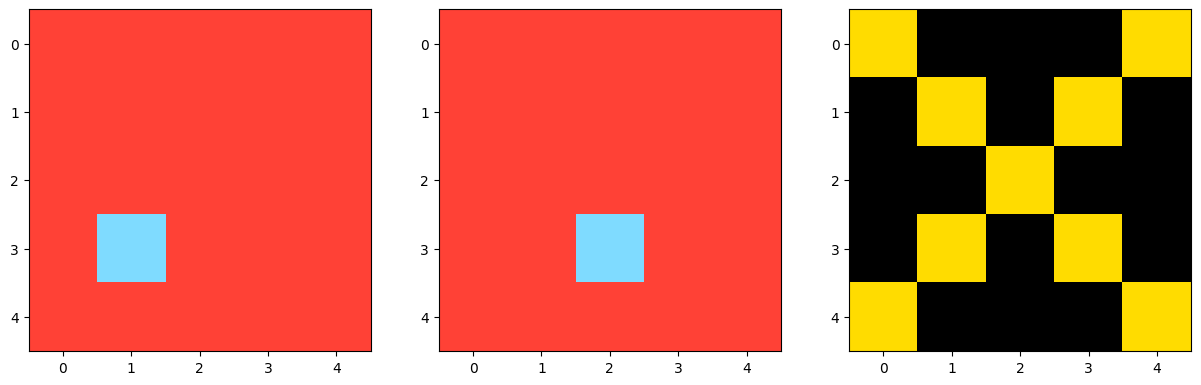

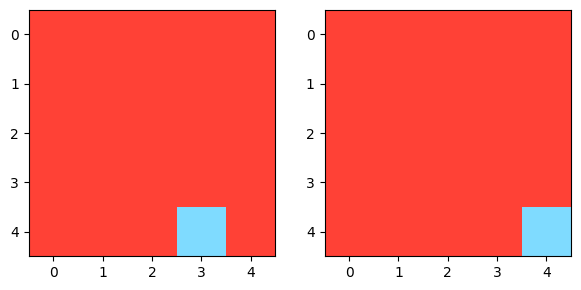

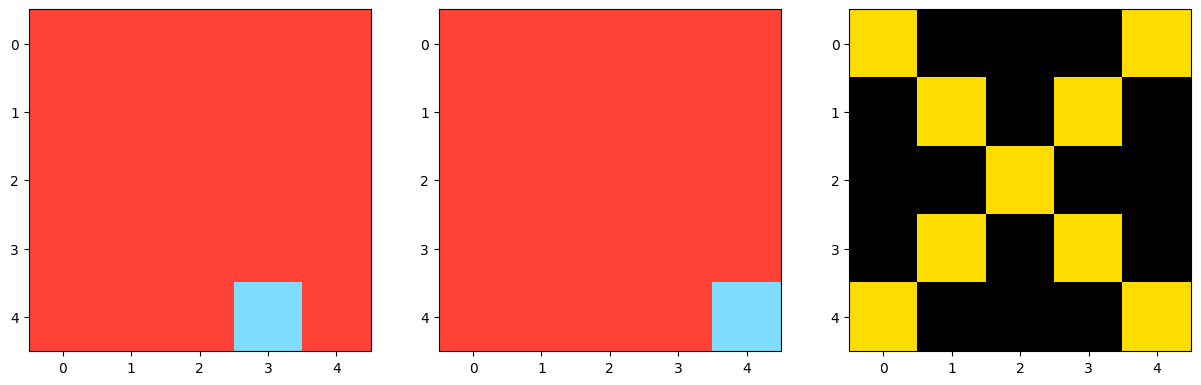

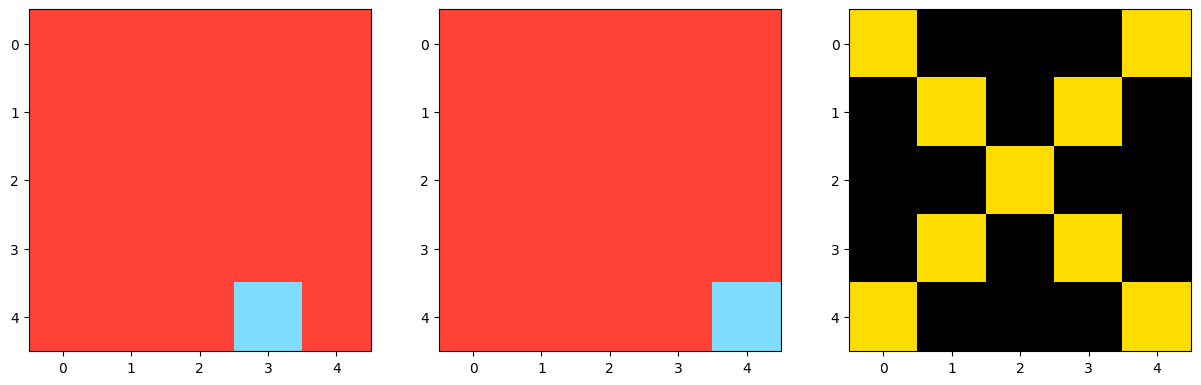

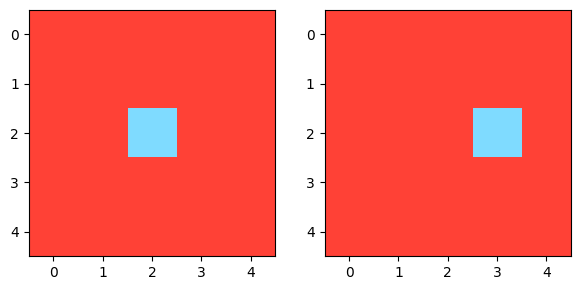

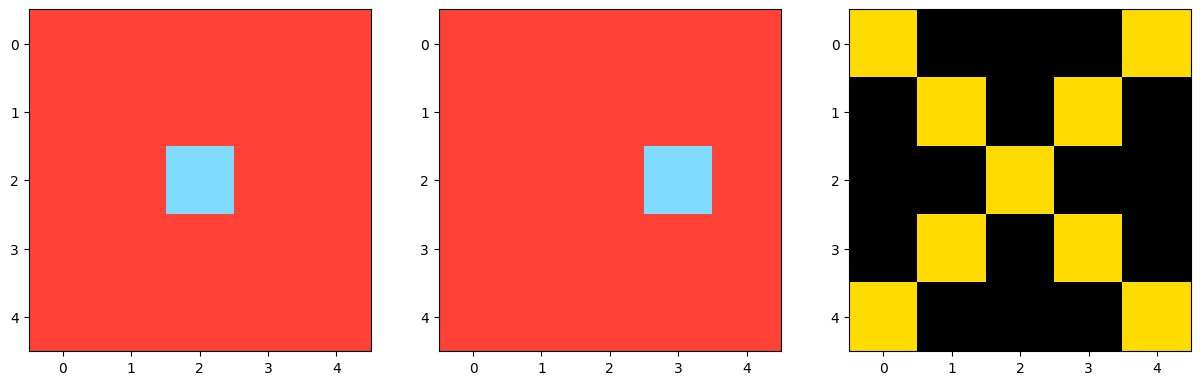

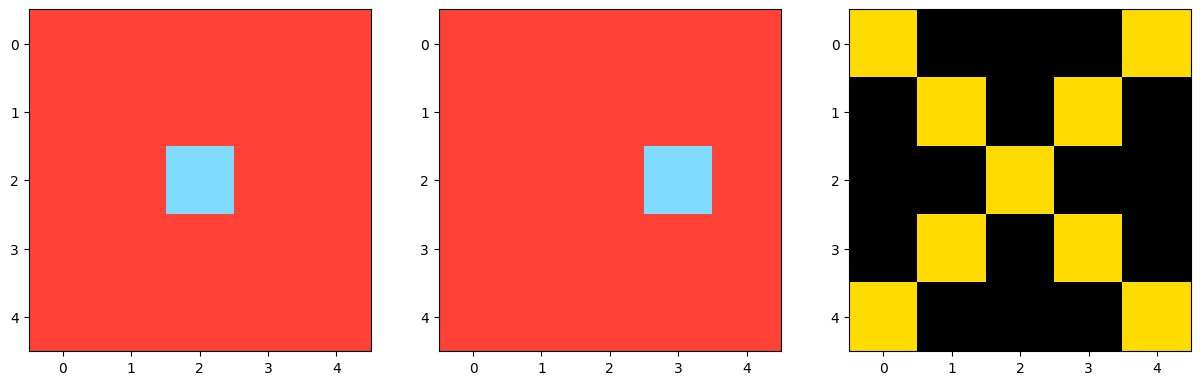

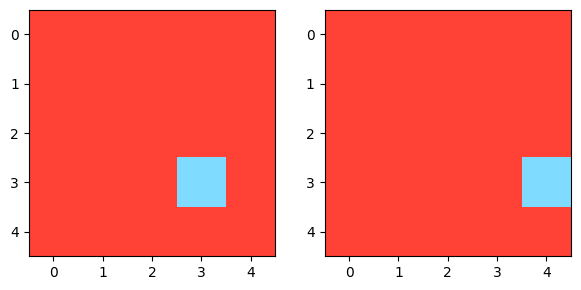

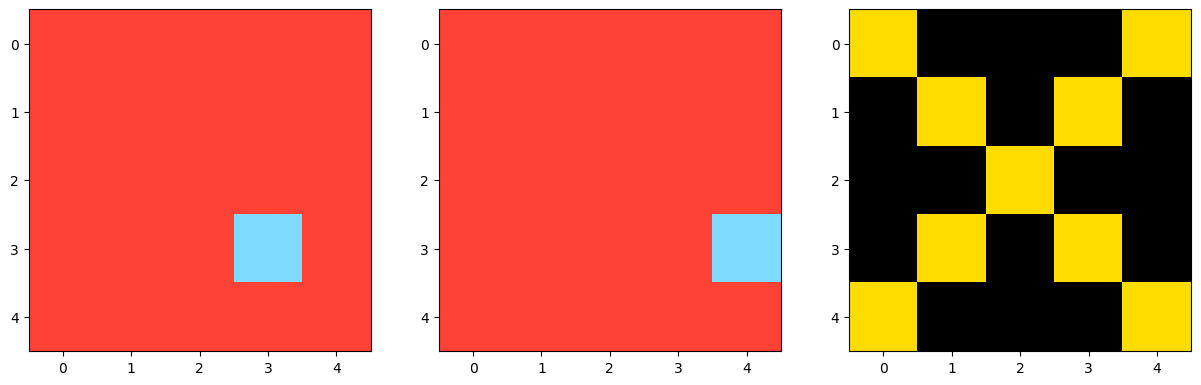

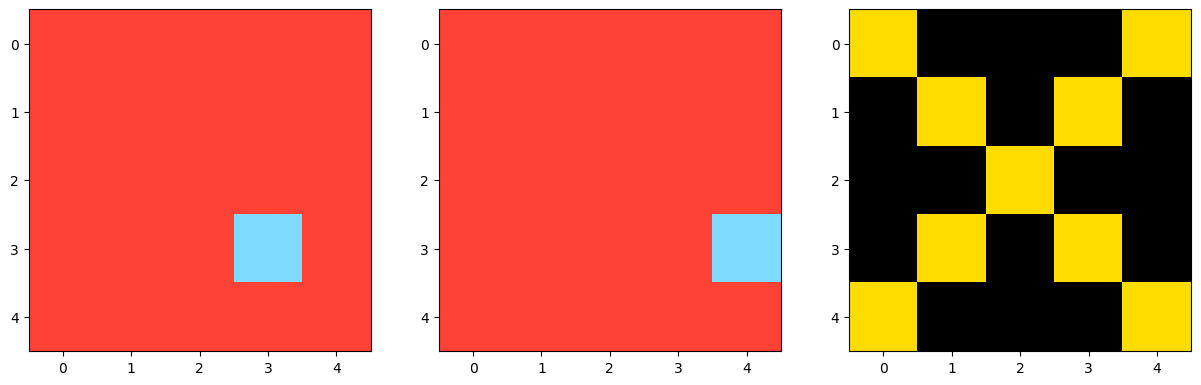

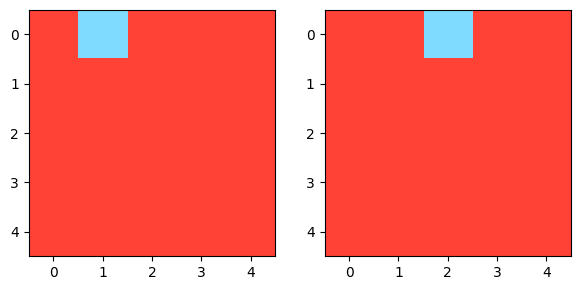

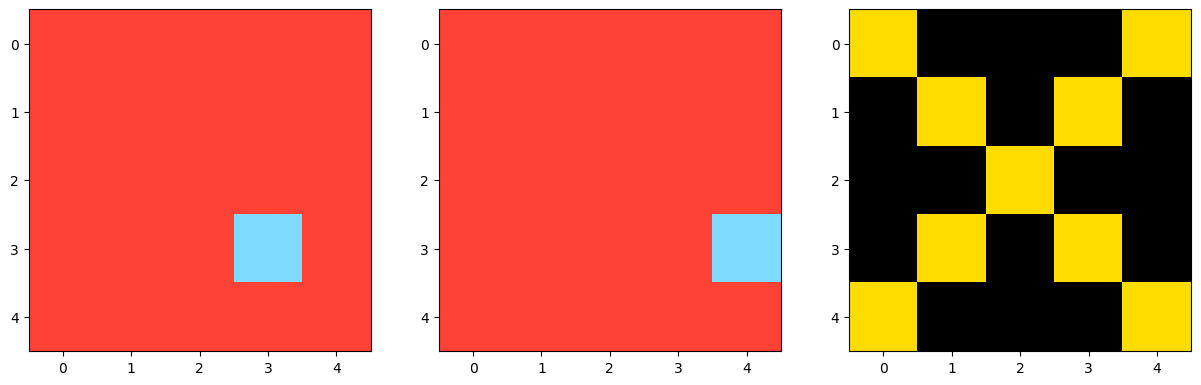

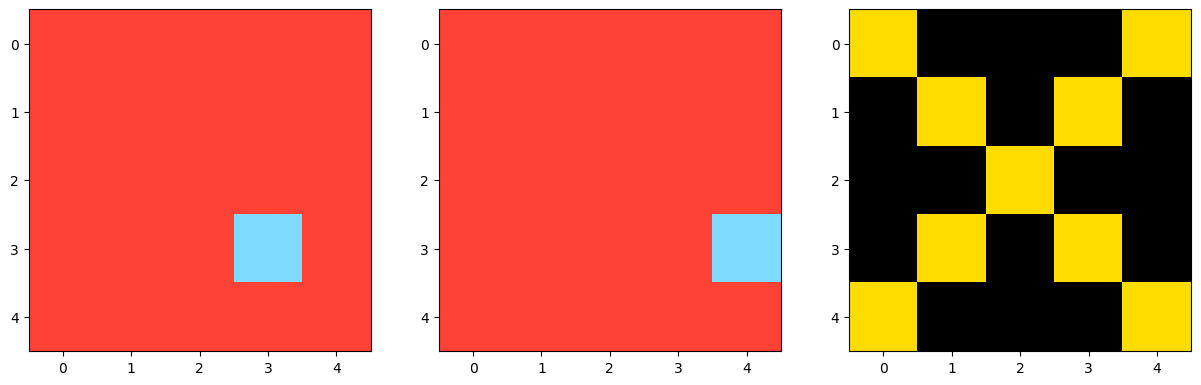

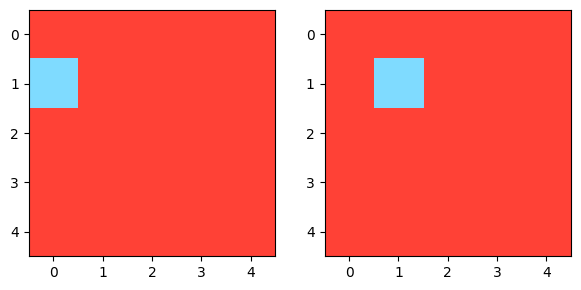

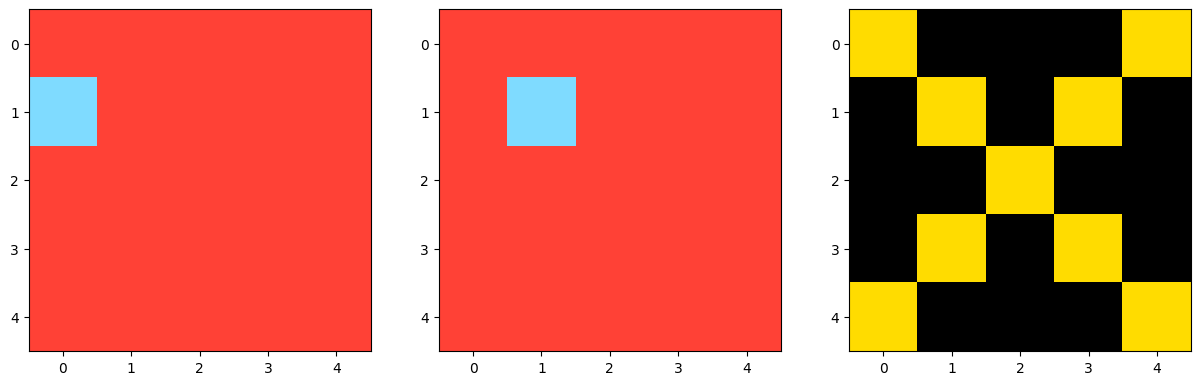

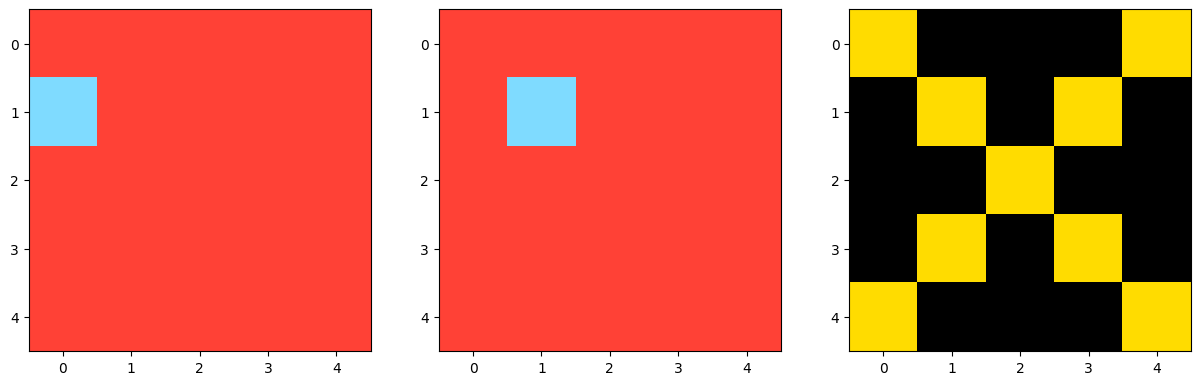

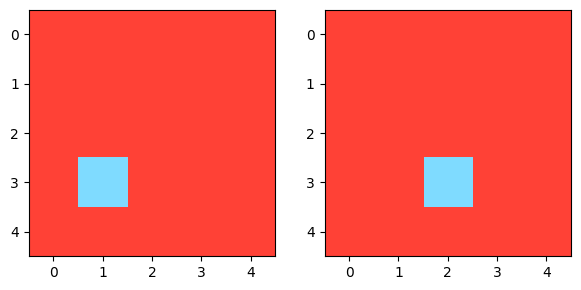

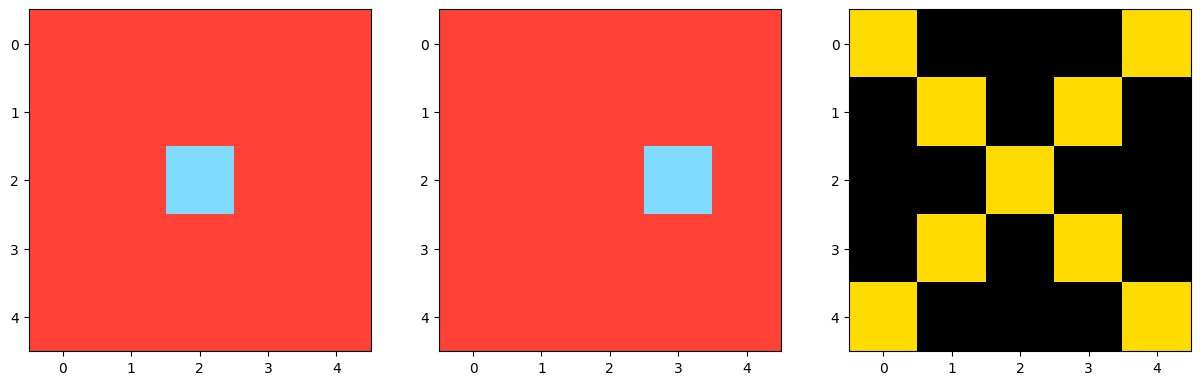

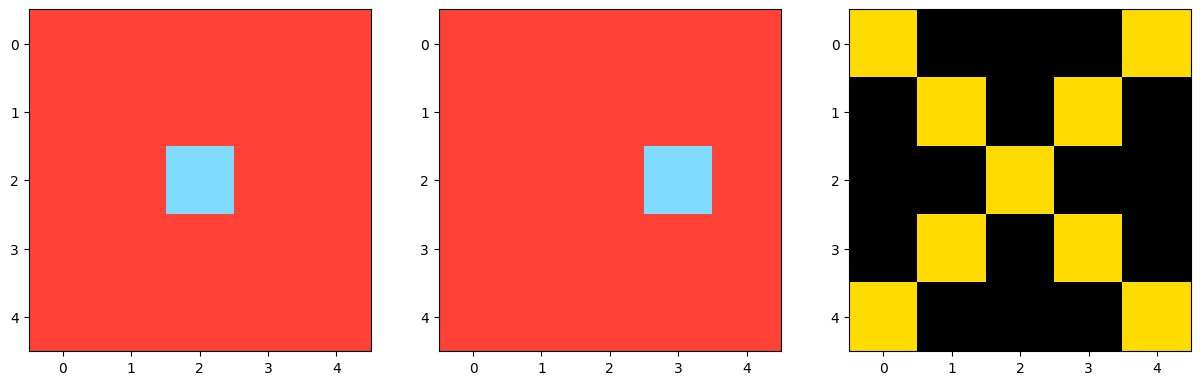

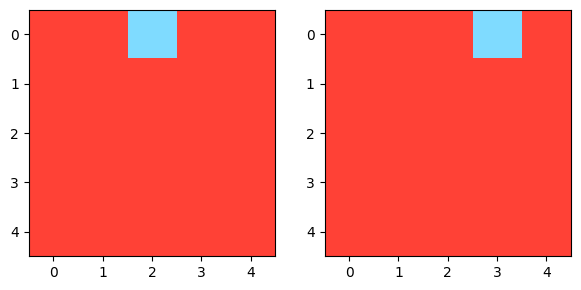

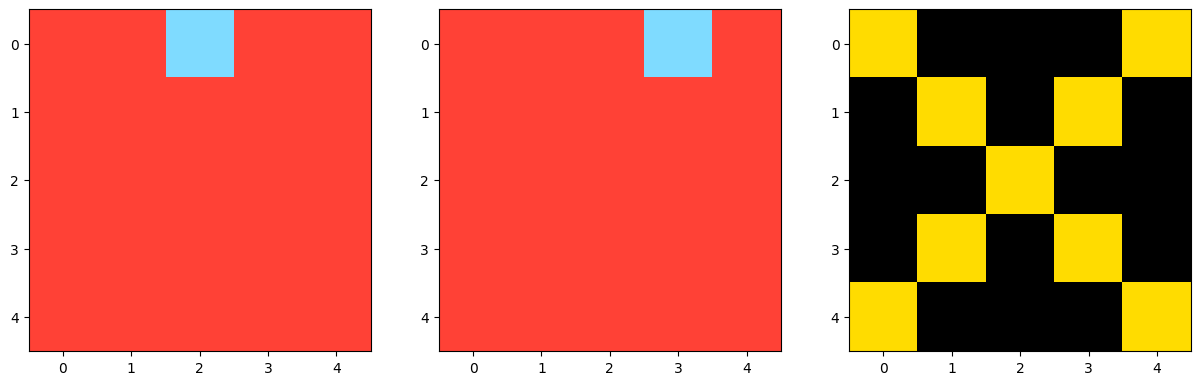

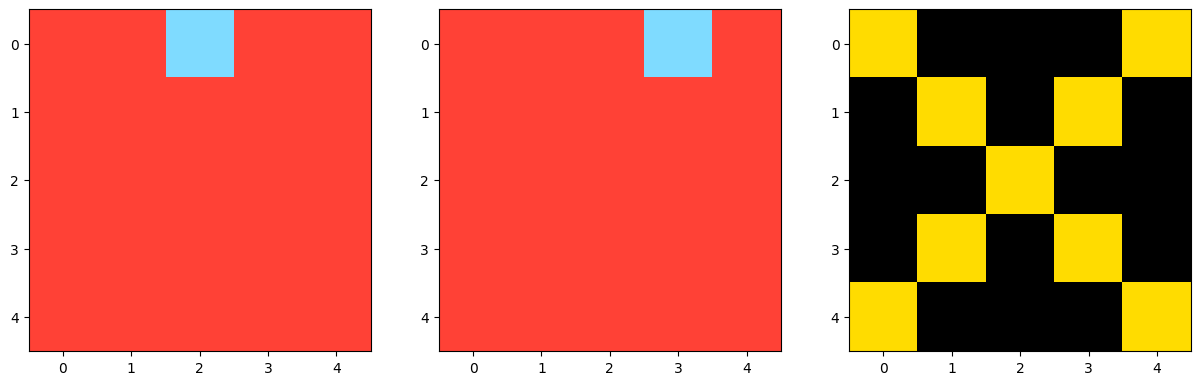

In [164]:
print (len(correct_idxs))
if len(correct_idxs) > 0:
  subset=[ correct_idxs[np.random.randint(0, len(correct_idxs))] for i in range(10) ]
  print(subset)
  solve_and_plot(training_set, subset)


## Plot Corresponding Test Tasks
These are the same training tasks with correct prediction in the Training set, but now we find those same tasks in the Test set.

In [165]:
crt = {}
for c in subset:
  task = training_set.labels[c].split("_")[0]
  if task in crt:
    crt[task]+=1
  else:
    crt[task]=0
print(len(crt)) # 24 / 400 - 6%
print(crt)

8
{'moveapixelxone-5x5-4842b6aaf6': 0, 'moveapixelxone-5x5-dd61478799': 0, 'moveapixelxone-5x5-3b6ec14321': 2, 'moveapixelxone-5x5-ee379bb171': 0, 'moveapixelxone-5x5-349674da1f': 0, 'moveapixelxone-5x5-100e3f2242': 0, 'moveapixelxone-5x5-dd6fc0acab': 0, 'moveapixelxone-5x5-10c47e4c10': 0}


Task index: 15, Input: moveapixelxone-5x5-4842b6aaf6_train_0|moveapixelxone-5x5-4842b6aaf6_test_0, Target: moveapixelxone-5x5-4842b6aaf6_train_0|moveapixelxone-5x5-4842b6aaf6_test_0
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.1496743239178347, shape=(), dtype=float64)
Task index: 41, Input: moveapixelxone-5x5-dd61478799_train_0|moveapixelxone-5x5-dd61478799_test_0, Target: moveapixelxone-5x5-dd61478799_train_0|moveapixelxone-5x5-dd61478799_test_0
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: False
Loss tf.Tensor(0.06111109346019386, shape=(), dtype=float64)
Task index: 13, Input: moveapixelxone-5x5-3b6ec14321_train_0|moveapixelxone-5x5-3b6ec14321_test_0, Target: moveapixelxone-5x5-3b6ec14321_train_0|moveapixelxone-5x5-3b6ec14321_test_0
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: True
Loss tf.Tensor(0.1637379907839878, shape=(), dtype=float64)
Task index: 45, Input: moveapixelxone-5x5-ee379bb171_tra

<ipython-input-155-4dd048e1be48>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(pred), figsize = (15, 20))


Task index: 4, Input: moveapixelxone-5x5-10c47e4c10_train_0|moveapixelxone-5x5-10c47e4c10_test_0, Target: moveapixelxone-5x5-10c47e4c10_train_0|moveapixelxone-5x5-10c47e4c10_test_0
Result Elements: 3, Accurate: False, Shape: (3, 5, 5, 3), Stopped: False
Loss tf.Tensor(0.13395927333517893, shape=(), dtype=float64)


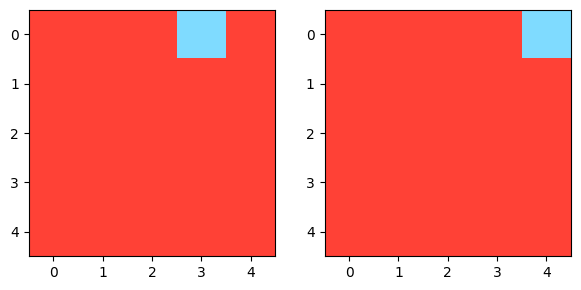

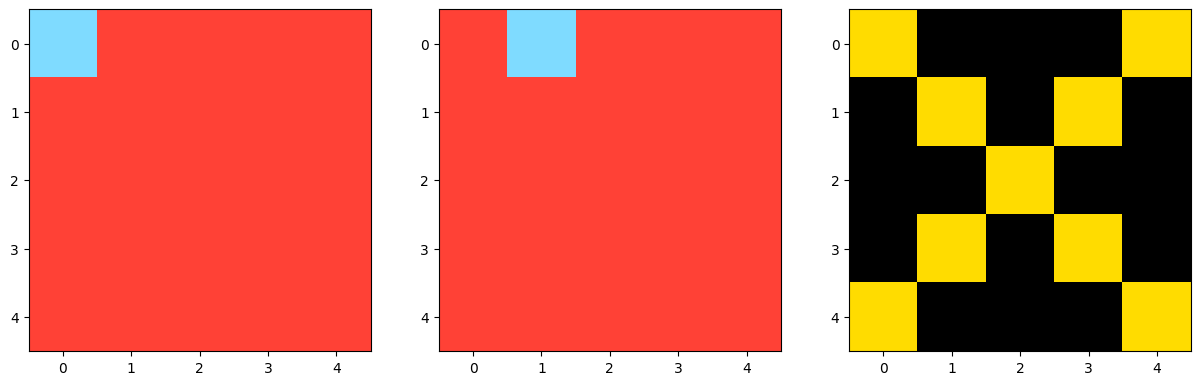

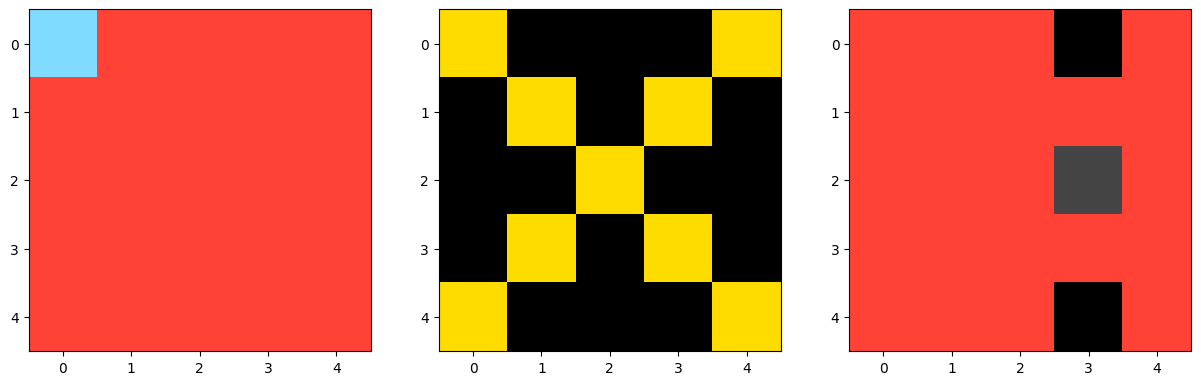

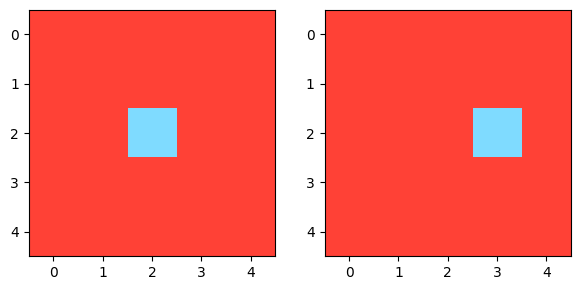

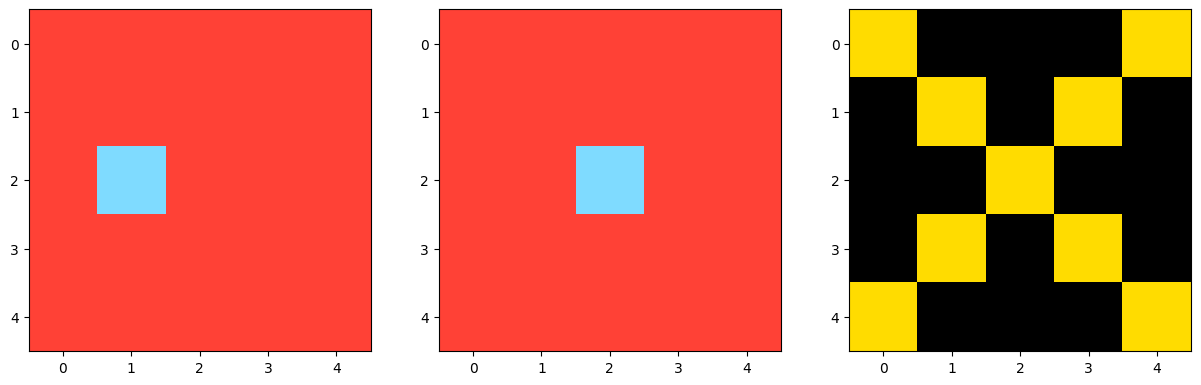

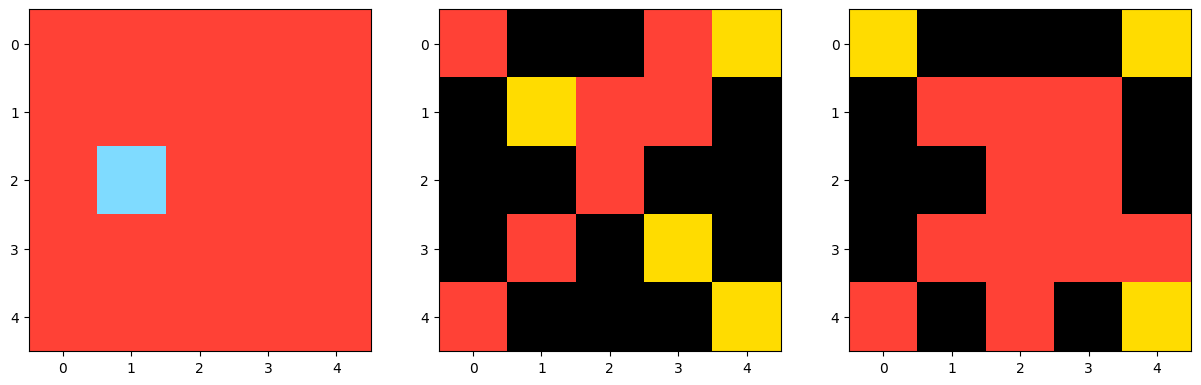

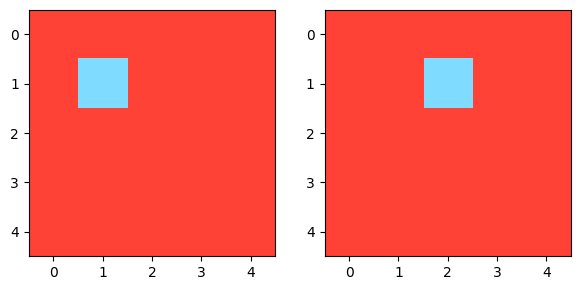

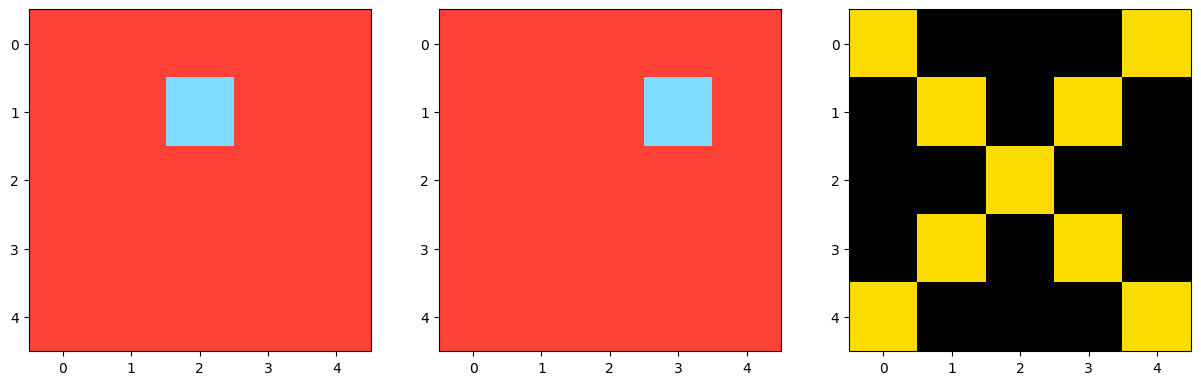

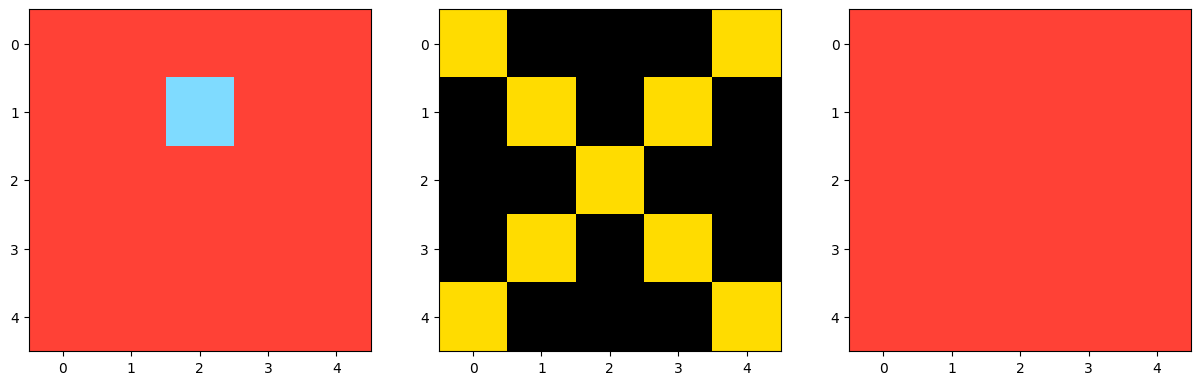

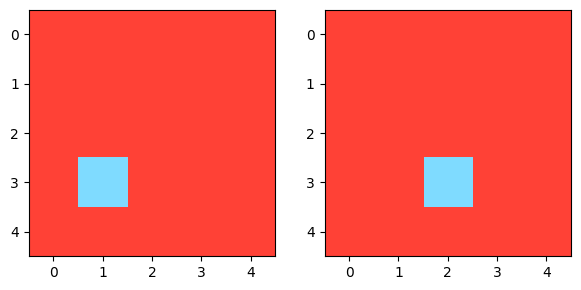

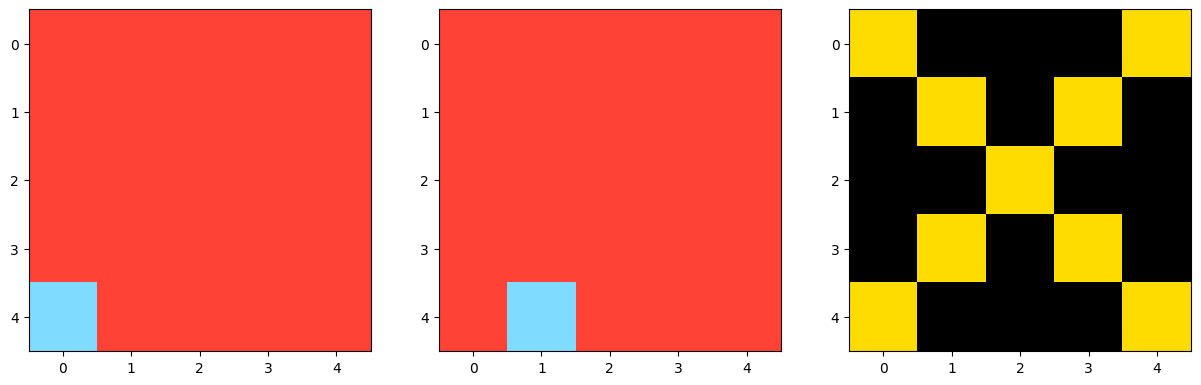

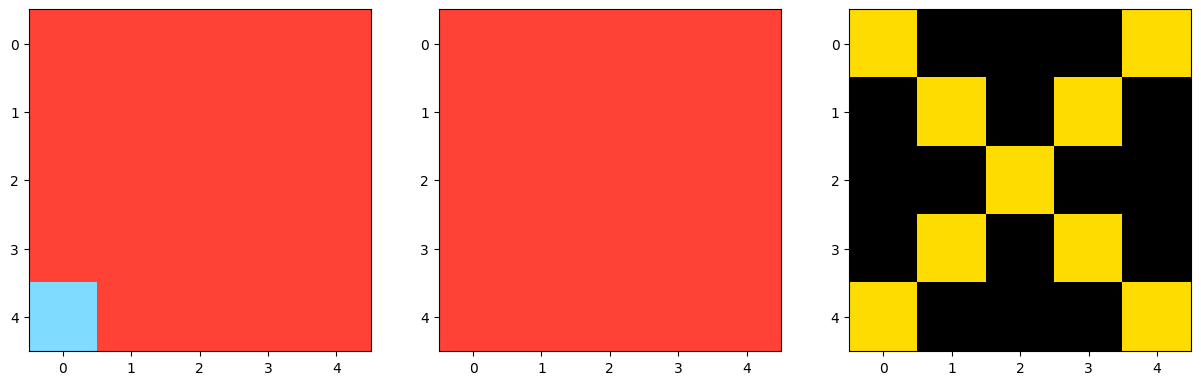

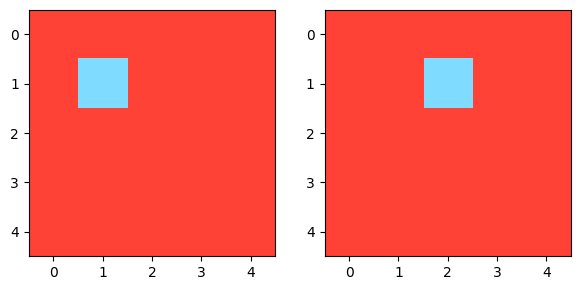

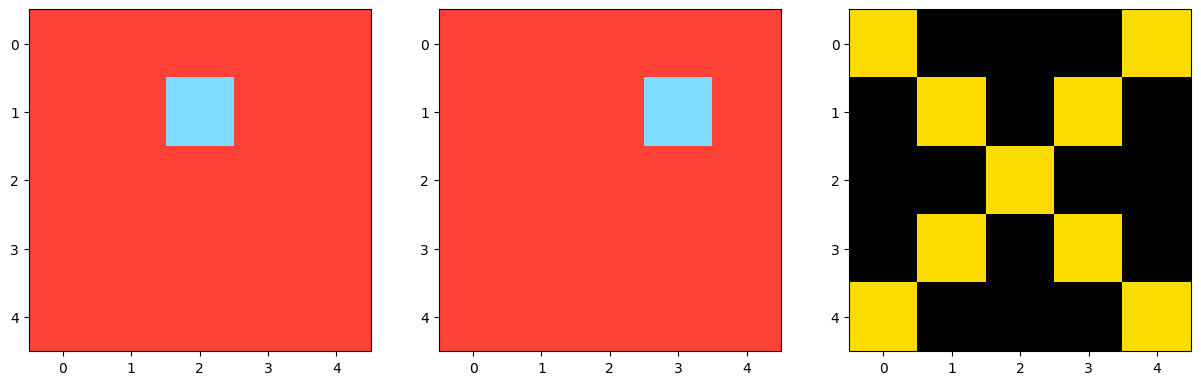

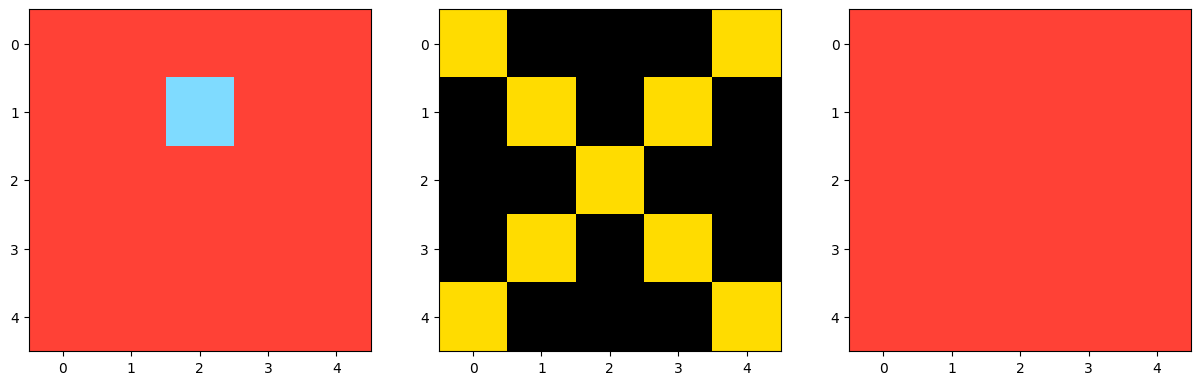

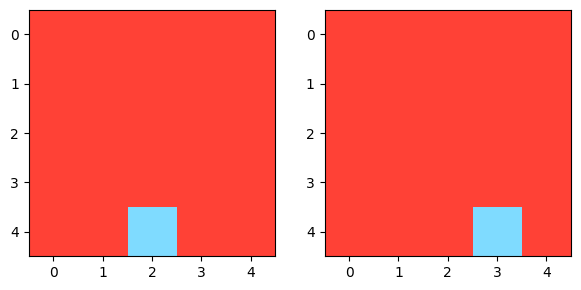

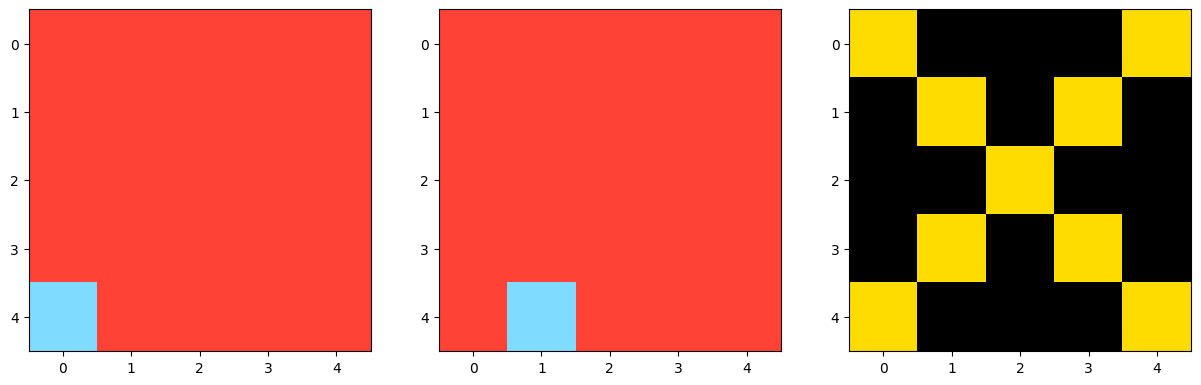

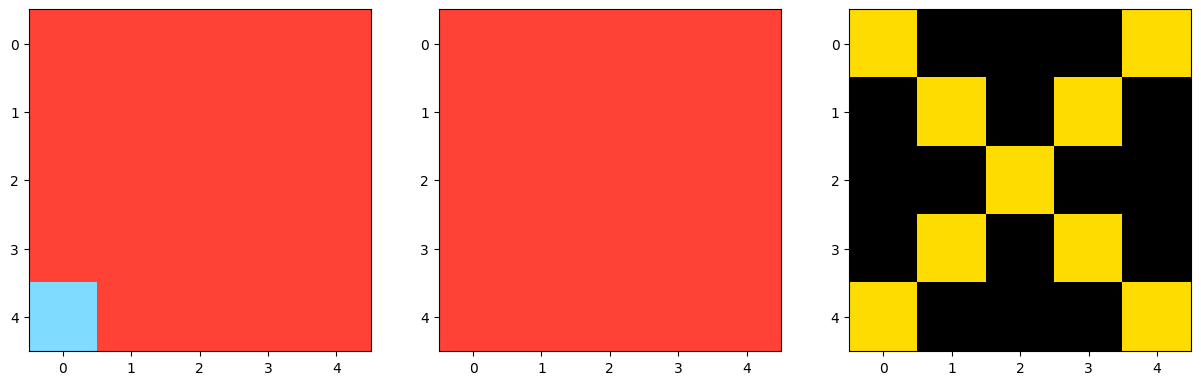

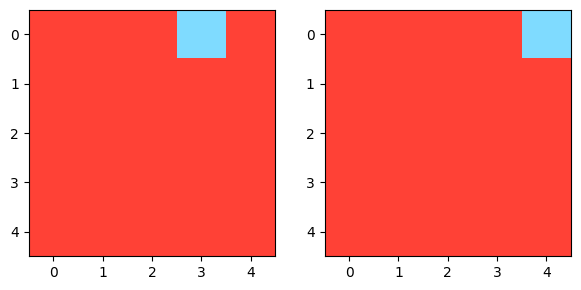

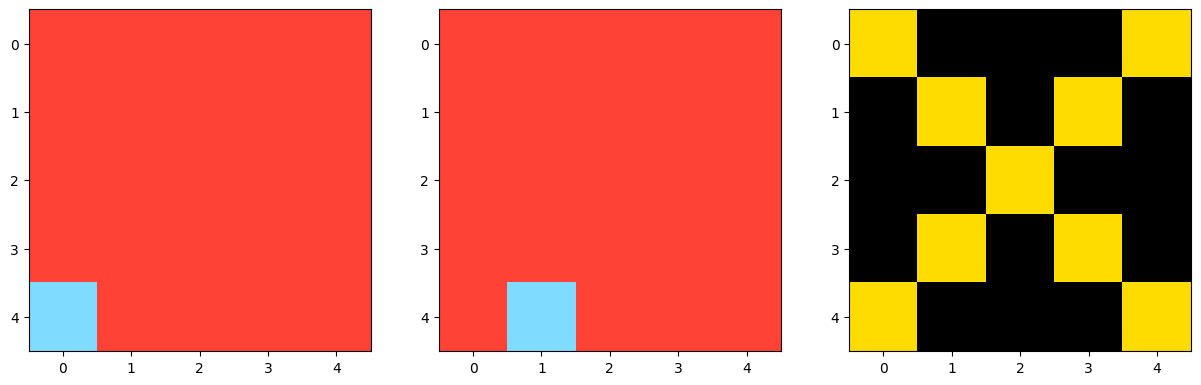

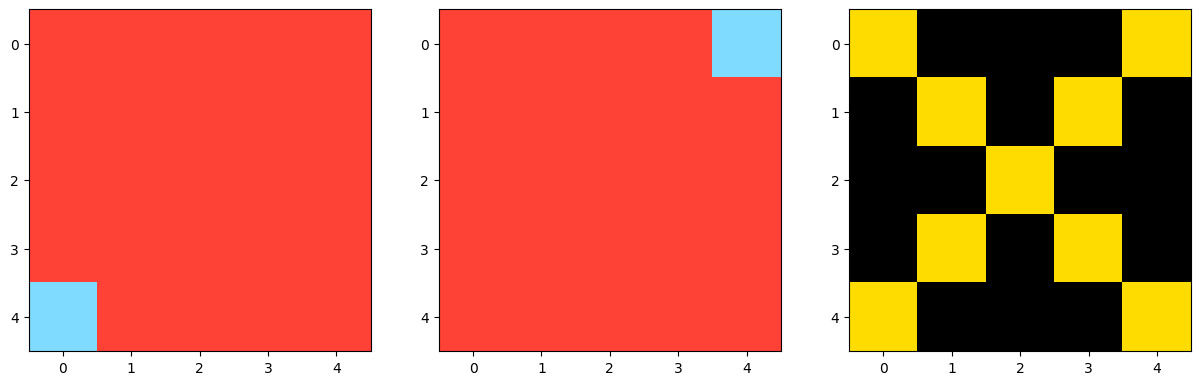

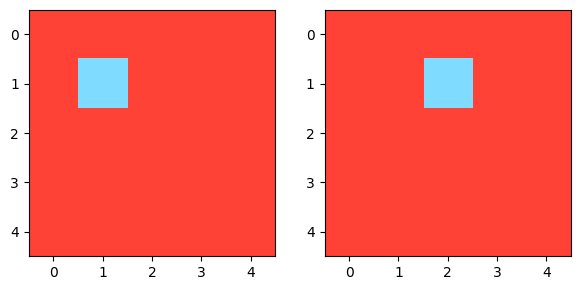

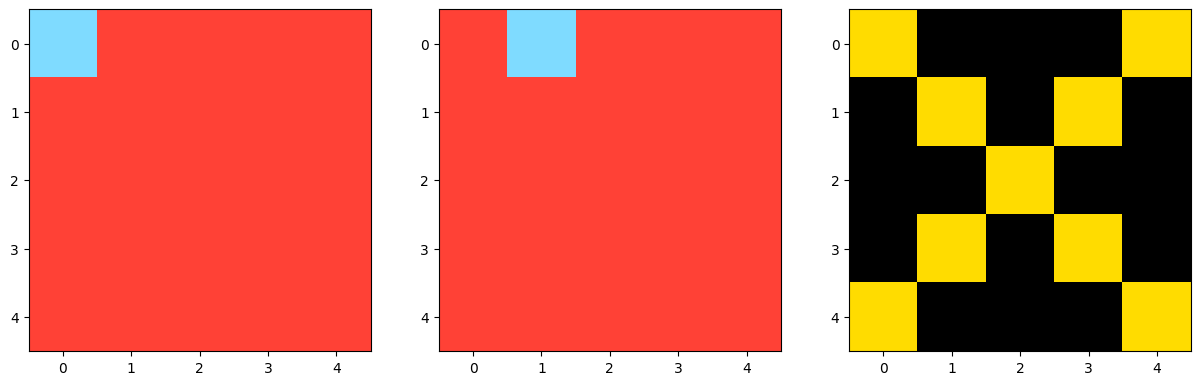

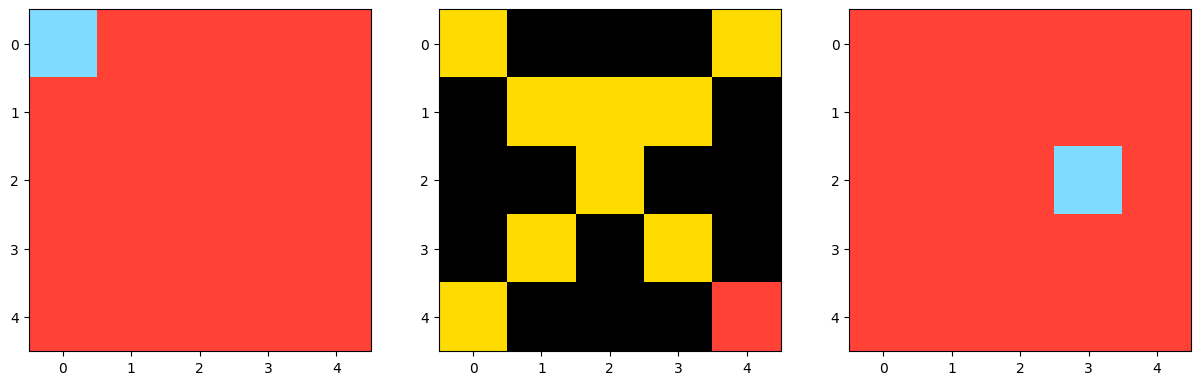

In [166]:
cases = [c+"_test_0" for c in crt.keys()]
inds = []
for c in cases:
    inds.append(next(i for i, s in enumerate(validatn_set.labels) if s.endswith(c)))
solve_and_plot(validatn_set, inds)


## Plot Incorrect Train Tasks

In [167]:
incorrect_idxs = [ x for x in range(len(training_set.labels[0])) if x not in correct_idxs ]
print(len(incorrect_idxs))
print(incorrect_idxs)
if len(incorrect_idxs) > 0:
  if len(incorrect_idxs) > 10:
    subset=[ incorrect_idxs[np.random.randint(0, len(incorrect_idxs))] for i in range(10) ]
  else:
    subset=incorrect_idxs
  print(subset)
  solve_and_plot(training_set, subset)

0
[]
